# Binding Site Analysis

In [1]:
import os,sys,inspect

path_to_project="/home/martalo/Documentos/TFM/GPCR_variants"
resultspath="/home/martalo/Documentos/TFM/GPCR_variants/Results/studied_GPCR_vars"
dictpath="/home/martalo/Documentos/TFM/GPCR_variants/Results/gpcr_to_pdb/"

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install bioservices
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install xlrd

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import urllib

import mdtraj as md
import itertools
from htmd.ui import *
from htmd.config import config
config(viewer='webgl')
import requests
import os
from matplotlib.ticker import FormatStrFormatter

!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import csv
import re

import analysis_common_functions as anls

/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/htmd/versionwarnings.py:29: UserWarning: As of HTMD 1.16 the default ACEMD version for all protocols has changed to version 3. If you want to use version 2 protocols change the _version argument in the protocols or add `config(acemdversion=2)` to the beginning of your scripts. To disable this warning run once: `from htmd import _disableWarnings; _disableWarnings('1.16');`
  , UserWarning)
/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/htmd/versionwarnings.py:33: UserWarning: As of HTMD 1.16 the default number of threads HTMD spawns for calculations is set to 1. You can enable parallelism at your own risk using `config(njobs=-2)` in the beginning of your scripts. To disable this warning run once: `from htmd import _disableWarnings; _disableWarnings('1.16');`
  , UserWarning)


ffevaluate module is in beta version
New devel HTMD version (1.24.7 python[3.6,<3.7.0a0,3.7,<3.8.0a0]) is available. You are currently on (1.19).There are several methods to update:    - Create a new conda env. using `conda create -n htmd1.24.7 htmd=1.24.7 -c acellera -c psi4 -c conda-forge`    - Create a brand new conda installation and run `conda install htmd -c acellera -c psi4 -c conda-forge`    - Run: `conda update htmd -c acellera -c psi4 -c conda-forge` (NOT RECOMMENDED)



In [2]:
# First read the data file:
# build a data frame
varDataFile="PTM_IMPACT/vars_A_impact_ptm_role4.csv"
# varDataFile="PTM_IMPACT/test.csv"
df = pd.read_csv(os.path.join(resultspath,varDataFile), delimiter =";") 
print(df.head()) 

/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   Number               Family                       Subamily  \
0       0  Aminergic receptors  5-Hydroxytryptamine receptors   
1       1  Aminergic receptors  5-Hydroxytryptamine receptors   
2       2  Aminergic receptors  5-Hydroxytryptamine receptors   
3       3  Aminergic receptors  5-Hydroxytryptamine receptors   
4       4  Aminergic receptors  5-Hydroxytryptamine receptors   

                              Name  Short Uniprot ID Uniprot entry  \
0  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
1  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
2  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
3  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
4  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   

                                      Struc             gene         varID  \
0  [Model]: 6G79 (Active) & 4IAQ (Inactive)  ENSG00000178394   rs752821044   
1  [Model]: 6G79 (Active) & 4IAQ

In [3]:
# IF THE DF FILE HAS CHANGE THE NAME OF THE GPCRS YOU SHOULD CHANGE IT ALSO IN analysis_common_functions!

# y axis, names of the class A receptors. Ex: '5-hydroxytryptamine receptor 1a (HTR1A)'
all_gpcrs_axes_set=set()
long=df['Name'].tolist()
short=df['Short'].tolist()
for l, s in list(zip(long, short)):    
    all_gpcrs_axes_set.add("%s (%s)" % (l,s))
all_gpcrs_axes_list=list(all_gpcrs_axes_set)

# order y-axis by alphabeticall order
all_gpcrs_axes=sorted(all_gpcrs_axes_list, key=str.lower)
print('Total number of GPCRs(rows of heatmap): ',len(all_gpcrs_axes))
# print(all_gpcrs_axes)

Total number of GPCRs(rows of heatmap):  287


## 1. Score analysis
Define the data frame, GPCR in the y axis, positions in the x axis. The colors will be: pale (score 0) for bening MVs, orange (1) for possibly damaging, red (2) damaging, and finally, white (3) for the ones that do not have information.

In [4]:

binding_site_gnum=['2x53', '2x56', '2x59', '2x60', '2x63', '2x64', '23x49', '23x50', '3x25', '3x28', '3x29', '3x32', '3x33', '3x35', '3x36', '3x37', '3x40', '4x56', '4x57', '45x50', '45x51', '45x52', '5x36', '5x37', '5x39', '5x40', '5x43', '5x44', '5x461', '5x47', '6x44', '6x48', '6x51', '6x52', '6x54', '6x55', '6x56', '6x58', '6x59', '7x30', '7x31', '7x34', '7x35', '7x37', '7x38', '7x39', '7x41', '7x42']

In [5]:
# x axis, positions of the residues that form the BS of class A AMINERGIC***

# build a data frame to display the heatmaps
gpcr_bspos=anls.build_dataFrame(binding_site_gnum)
# cols are the residues of the binding site of all GPCRs, the rows are the names
# of the class A GPCRs
# initially all the values of the matrix set to 3 (that will correspond to the cells without data)

# Now we have to fill in the df with 0,1,2 depending on the impact score:
# gpcr_bspos[bspos][gpcrname]= 0,1 or 2
anls.fill_in_dataFrame(gpcr_bspos, binding_site_gnum, df)

#display the result as a heatmap
# anls.heatmap_only(gpcr_bspos)

Now we will add the option of number of variants order and the sum by column and row. First, sum by row, order by number of varinats or not. We will do the separation score 1 and score 2. 

In [6]:
# Sum variants of each GPCR
# Change the number to display the sum of possibly damaging (1) or damaging (2)
# Add 'False' (4th element)  to hide the heatmap, otherwise the barplot will appear below
# Add 'True' (5th element) if you want to order the columns by increasing number of MVs

# anls.heatmap_horizontal_sum(gpcr_bspos,binding_site_gnum,2, False)

Now we will put in the same barplot both score 1 and score 2. Without the option to order by incresing number of variants.

ADD THE OPTION TO SORT! If needed, by now is only alphabetically

In [7]:
# Sum variants of each GPCR, barplot below heatmap, with damaging (red) and possibly damaging (orange)
# anls.heatmap_horizontal_sum_mixed(gpcr_bspos)

Now we will add the sum by position, by column.

In [8]:
# anls.heatmap_vert_sum_mixed(gpcr_bspos,binding_site_gnum)

## 2. Disease Analysis

In [9]:
gpcr_bspos_dis=anls.build_dataFrame(binding_site_gnum,0)
anls.fill_in_dataFrame_diseases(gpcr_bspos_dis,binding_site_gnum,df)
# anls.heatmap_only_diseases(gpcr_bspos_dis)

### 2.1 Diasese heatmap compact

In [10]:
def computeDimensions(listGnum,df,parameter,yaxis=all_gpcrs_axes):
    '''Print GPCRs and Pos that have dis/PTM (depending on the parameter)
    return a list len of GPCRs and len of pos'''
    dim=[]
    gpcrDis=set()
    posDis=set()
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), parameter].tolist()
            if len(disList)>0:
                if 'Yes' in disList or 'yes' in disList:
                    print(ibspos, gpcr,disList)
                    gpcrDis.add(gpcr)
                    posDis.add(ibspos)
    print('Set of GPCrs and len',gpcrDis,len(gpcrDis))
    print('Set of positions and len',posDis,len(posDis))
    dim.append(len(gpcrDis))
    dim.append(len(posDis))
    return dim

dimension=computeDimensions(binding_site_gnum,df,'disease')
dimension=[35, 35]
gpcrsDis=['PROKR2', 'AVPR1A', 'P2RY12', 'LPAR6', 'EDNRA', 'TAAR1', 'OPN2', 'HTR2C', 'MC2R', 'SSTR4', 'CXCR4', 'OPN1LW', 'MC1R', 'GALR2', 'ADRA1A', 'CYSLTR2', 'GPR101', 'ADRB2', 'SSTR3', 'AVPR2', 'TACR3', 'CCR2', 'FPR1', 'EDNRB', 'KISS1R', 'TSHR', 'GNRHR', 'NPSR1', 'LHCGR', 'MC4R', 'FSHR', 'OPRM1', 'OXER1', 'CX3CR1', 'CCR5']
# posDis=['23x49', '45x50', '3x28', '3x35', '5x39', '6x48', '7x41', '6x55', '7x35', '7x31', '2x63', '5x43', '5x461', '7x37', '6x52', '2x59', '3x25', '2x60', '45x51', '4x56', '5x36', '6x59', '3x32', '7x42', '45x52', '4x57', '7x34', '6x44', '5x47', '3x36', '3x40', '3x37', '5x44', '3x29', '2x53']
# posDis.sort()
posDis=[ '2x53', '2x59', '2x60','2x63', '23x49', '3x25', '3x28', '3x29', '3x32', '3x35', '3x36', '3x37', '3x40', '4x56', '4x57', '45x50', '45x51', '45x52', '5x36', '5x39', '5x43', '5x44', '5x461', '5x47', '6x44', '6x48', '6x52', '6x55', '6x59', '7x31', '7x34', '7x35', '7x37', '7x41', '7x42']

# print(posDis)

# print(len(posDis))

5x461 HTR2C ['Yes']
7x31 ADRA1A ['Yes', 'No', 'No', 'No']
7x37 ADRA1A ['No', 'No', 'No', 'Yes', 'No']
4x56 ADRB2 ['Yes']
3x37 AVPR1A ['Yes', 'No']
5x36 AVPR2 ['Yes', 'No']
7x42 CCR2 ['Yes', 'Yes', 'No']
7x34 CCR5 ['No', 'Yes']
23x49 CXCR4 ['Yes']
2x60 CX3CR1 ['Yes']
5x39 CYSLTR2 ['Yes']
2x53 EDNRA ['Yes']
3x35 EDNRA ['Yes']
2x53 EDNRB ['Yes', 'Yes']
7x31 EDNRB ['Yes']
3x32 FSHR ['Yes']
45x52 FSHR ['Yes']
3x28 FPR1 ['Yes', 'Yes']
5x44 GPR101 ['Yes']
6x48 GALR2 ['Yes', 'No']
2x53 GNRHR ['Yes']
23x49 GNRHR ['Yes']
3x40 GNRHR ['Yes', 'Yes', 'Yes', 'No']
4x57 GNRHR ['No', 'Yes']
6x52 GNRHR ['Yes']
2x63 KISS1R ['Yes']
7x42 KISS1R ['Yes']
7x37 OPN1LW ['Yes']
6x44 LHCGR ['Yes']
5x43 LPAR6 ['Yes', 'Yes']
5x44 LPAR6 ['Yes']
3x25 MC1R ['Yes', 'Yes']
3x28 MC1R ['Yes']
3x36 MC1R ['No', 'Yes', 'Yes', 'No']
5x47 MC1R ['Yes', 'Yes']
3x25 MC2R ['No', 'Yes']
3x29 MC2R ['Yes']
2x63 MC4R ['Yes']
3x40 MC4R ['Yes', 'No']
4x56 MC4R ['Yes']
4x57 MC4R ['Yes']
6x59 MC4R ['Yes']
2x63 NPSR1 ['No', 'Yes']
2x63 OPR

In [11]:
def fill_in_dataFrame_diseasesOnly(dataFrame, listGnum, df,disPos,disGpcr,yaxis=all_gpcrs_axes):
    '''Fill in the df with 0,1,2,.. depending on the number of related diseases.
    MAYBE tune with T/F to only the vars with impact score 2'''
    p=re.compile(".*\((\w*)\)")
    difNums=set()
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            if ibspos in disPos and gpcr in disGpcr:
                value=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'related_diseases'].tolist()
                disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'disease'].tolist()
                if len(disList)>0:
                    if 'Yes' in disList or 'yes' in disList:
                        dis='Yes'#Yes/No
                    else:
                        dis='No'
                else:
                    dis='No'
                if len(value)>0:#if there are matches, non-void list   
                    numValues=[x for x in value if x>=0]#avoid NaN
                    if numValues:
                        valueOk=max(numValues)
#                         print(gpcr, ibspos, value, valueOk)
    #                     print('Max value',valueOk)
                if dis=='Yes': 
                    dataFrame[ibspos][gpcr]=valueOk # we will take tha max in case there
                    difNums.add(valueOk)
#                     print(ibspos, gpcrname,dataFrame[ibspos][gpcr])
                    # are two rows matching
                    #  if value equal to NaN, te cell will be zero
    return difNums


disOnly=pd.DataFrame(columns=posDis,index=gpcrsDis).fillna(value=0)
difNumsResDis=fill_in_dataFrame_diseasesOnly(disOnly,binding_site_gnum,df,posDis,gpcrsDis)
# anls.heatmap_only_diseases(disOnly)

In [12]:
#check number of positions
def pos_diseasesOnly(listGnum, df,yaxis=all_gpcrs_axes):
    '''Build list of positions that have related diseases'''
    p=re.compile(".*\((\w*)\)")
    posList=[]
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'disease'].tolist()
            if len(disList)>0:# mal
                dis=disList[0]#Yes/No
            else:
                dis='Out region'
            if dis=='Yes':                     
                posList.append(ibspos)
#                     print(ibspos, gpcrname,dataFrame[ibspos][gpcr])
                # are two rows matching
                #  if value equal to NaN, te cell will be zero
    return posList


# listPos=pos_diseasesOnly(binding_site_gnum,df)
# listPos=['5x461', '7x31', '4x56', '3x37', '5x36', '7x42', '23x49', '2x60', '5x39', '2x53', '3x35', '2x53', '7x31', '3x32', '45x52', '3x28', '5x44', '6x48', '2x53', '23x49', '3x40', '6x52', '2x63', '7x42', '6x44', '5x43', '5x44', '3x25', '3x28', '5x47', '3x29', '2x63', '3x40', '4x56', '4x57', '5x461', '6x59', '2x63', '2x59', '2x63', '45x52', '6x55', '7x41', '7x35', '7x42', '4x57', '6x44', '45x50']
# print(listPos)
# setPos=set()# conver list to set to check how many positions are related with diseases
# for element in listPos:
#     setPos.add(element)
# print(len(listPos), len(setPos))

2021-04-16 09:08:37,443 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


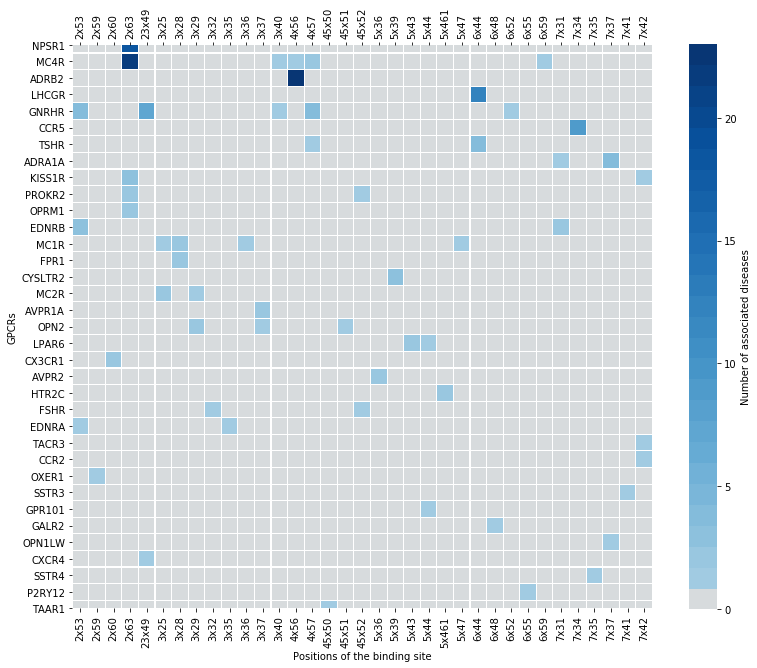

In [13]:
# heatmap and barplots graphs
def heatmap_only_diseases_nonZero(dataFrame,colorPalette='YlOrRd'):
    '''Plot the data frame than contains the color scale for the diseases'''
    color_map_sns=sns.color_palette(colorPalette,n_colors=40).as_hex()
    fig, ax = plt.subplots(figsize=(13,13))
    color_map=color_map_sns[14:]
    color_map.insert(0,'#d7dbdd')
    
    
    ax2=sns.heatmap(dataFrame, cmap=color_map, linewidths=0.1, annot=False, 
        square=True,xticklabels=True, yticklabels=True,ax=ax,cbar=True,cbar_kws={"shrink": .80,'label':'Number of associated diseases'})
    
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
#     ax2.xaxis.set_ticks_position('top')
    
    plt.xticks(rotation=90) 
    
    ax2.set(xlabel='Positions of the binding site', ylabel='GPCRs')
    plt.show()
    return None

disOnlyClus=anls.cluster_df(disOnly)#cluster the dataframe
heatmap_only_diseases_nonZero(disOnlyClus,'Blues')
# disease/heatmapOnlyDis.png

In [14]:
# numer of associated diseases of the previous heatmap
difNumsResDis

{1.0, 2.0, 3.0, 4.0, 7.0, 9.0, 12.0, 18.0, 22.0, 23.0}

+ The variant of ADRB2, rs1800888, position 4x56 is related with 23 diseases including: different respiratory diseases, diabetes, circulatory problems, etc. Tagged as BENING (changed).
+ The variant of MC4R, rs2229616, 2x63: related with 22 diseases: methabolic disorders, diabetis, etc. Tagged as BENING (similar).
+ The variants of NPSR1, rs324981, 2x63: related with 18 diseases, mental disorders (panic, anxiety, TDA, schizophrenia, agoraphobia, etc). Tagged as BENING, SIFT 1 and PolyPhen2 0 (changed).

The position 2x63 is the one related with the higher number of diseases (47) but it does not mean that they are DAMAGING or POSSIBLY DAMAGING.

## 3. PTM
First we visualize all the positions that are any kind of PTMs: modRes, glycosilation, lipidation, disulfide bond, all of them in pink. This is done using the column 'PTM', the cells with 'yes' will be displayed.

In [15]:
# all PTMs in pink
gpcr_bspos_ptm=anls.build_dataFrame(binding_site_gnum,0) # first all Zeros
# now fill in the df 'gpcr_bspos_ptm' with '1' if there is a 'yes' in the original dataframe
ptmValues=anls.fill_in_dataFrame_ptm(gpcr_bspos_ptm,binding_site_gnum,df)
# it will also return True/False depending if there are any PTMs

In [16]:
# if there is some PTM for this region
# if ptmValues:
#     anls.heatmap_only_ptm(gpcr_bspos_ptm)

In [17]:
# how many PTMs in each column
# pd.set_option("max_rows", None)
# pd.reset_option('max_rows')
def count_ptms(df,pos):
    count=0
    for element in df[pos]:
        if element != 0:
            count+=1
    return count

print('Total PTMs in 3x25:')
print(count_ptms(gpcr_bspos_ptm, '3x25'))

print('Total PTMs in 45x50:')
print(count_ptms(gpcr_bspos_ptm, '45x50'))

print('Total PTMs in 45x25:')
print(count_ptms(gpcr_bspos_ptm, '45x52'))

print('Total PTMs in 5x36:')
print(count_ptms(gpcr_bspos_ptm, '5x36'))

print('Total PTMs in 6x58:')
print(count_ptms(gpcr_bspos_ptm, '6x58'))

print('Total PTMs in 7x42:')
print(count_ptms(gpcr_bspos_ptm, '7x42'))


Total PTMs in 3x25:
72
Total PTMs in 45x50:
71
Total PTMs in 45x25:
1
Total PTMs in 5x36:
1
Total PTMs in 6x58:
1
Total PTMs in 7x42:
3


Now we will see each type separatelly using the pink color scale:

In [18]:
# we need to build a dataframe with the PTM information
gpcr_bspos_ptm_types=anls.build_dataFrame(binding_site_gnum,0)
# we will fill each cell with different numeric values to represent in each PTM type
# 7 - ModRes   8 - Glyco   9 - Lipid  10 - DB
# from soft pink to fucsia


In [19]:
def fill_in_dataFrame_ptm_type(dataFrame, listGnum, typePTM, df,yaxis=all_gpcrs_axes):
    '''Fill in the dataFrame with 0,7,8,9,10 depending of the PTM type of the variant. 
    0 - noPTM   7 - ModRes   8 - Glyco   9 - Lipid  10 - DB '''
    ptmScores={'Modified Residue':7, 'Glycosylation':8, 'Lipidation':9, 'Disulfide Bond':10}
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            value=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), typePTM].tolist()   
            print(gpcr,ibspos,value)
            if len(value)>=1 and type(value[0])!=float:#check that the cell is not void or nan
                print('In the if:',gpcrname,ibspos,value)
                print('ok')
                dataFrame[ibspos][gpcrname]=ptmScores[typePTM] # if it is a PTM position set 
                # the corresponding score
            #  if value equal to NaN or void, te cell will be zero
    return None

In [20]:
#modRes df
gpcr_bspos_ptm_modRes=anls.build_dataFrame(binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_bspos_ptm_modRes,binding_site_gnum,'Modified Residue',df)

#glyco df
gpcr_bspos_ptm_glyco=anls.build_dataFrame(binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_bspos_ptm_glyco,binding_site_gnum,'Glycosylation',df)

#lipid df
gpcr_bspos_ptm_lipid=anls.build_dataFrame(binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_bspos_ptm_lipid,binding_site_gnum,'Lipidation',df)

#DB df 
gpcr_bspos_ptm_db=anls.build_dataFrame(binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_bspos_ptm_db,binding_site_gnum,'Disulfide Bond',df)

In [21]:
print('Total DBs in 3x25:')
print(count_ptms(gpcr_bspos_ptm_db, '3x25'))

print('Total DBs in 45x50:')
print(count_ptms(gpcr_bspos_ptm_db, '45x50'))

print('Total glycos in 45x25:')
print(count_ptms(gpcr_bspos_ptm_glyco, '45x52'))

print('Total glycos in 5x36:')
print(count_ptms(gpcr_bspos_ptm_glyco, '5x36'))

print('Total glycos in 6x58:')
print(count_ptms(gpcr_bspos_ptm_glyco, '6x58'))

print('Total ModRes in 7x42:')
print(count_ptms(gpcr_bspos_ptm_modRes, '7x42'))
len( gpcr_bspos_ptm_modRes.index)

Total DBs in 3x25:
72
Total DBs in 45x50:
71
Total glycos in 45x25:
1
Total glycos in 5x36:
1
Total glycos in 6x58:
1
Total ModRes in 7x42:
3


287

['#EDEDF4', '#fcacd0', '#f8589e', '#801f4a']


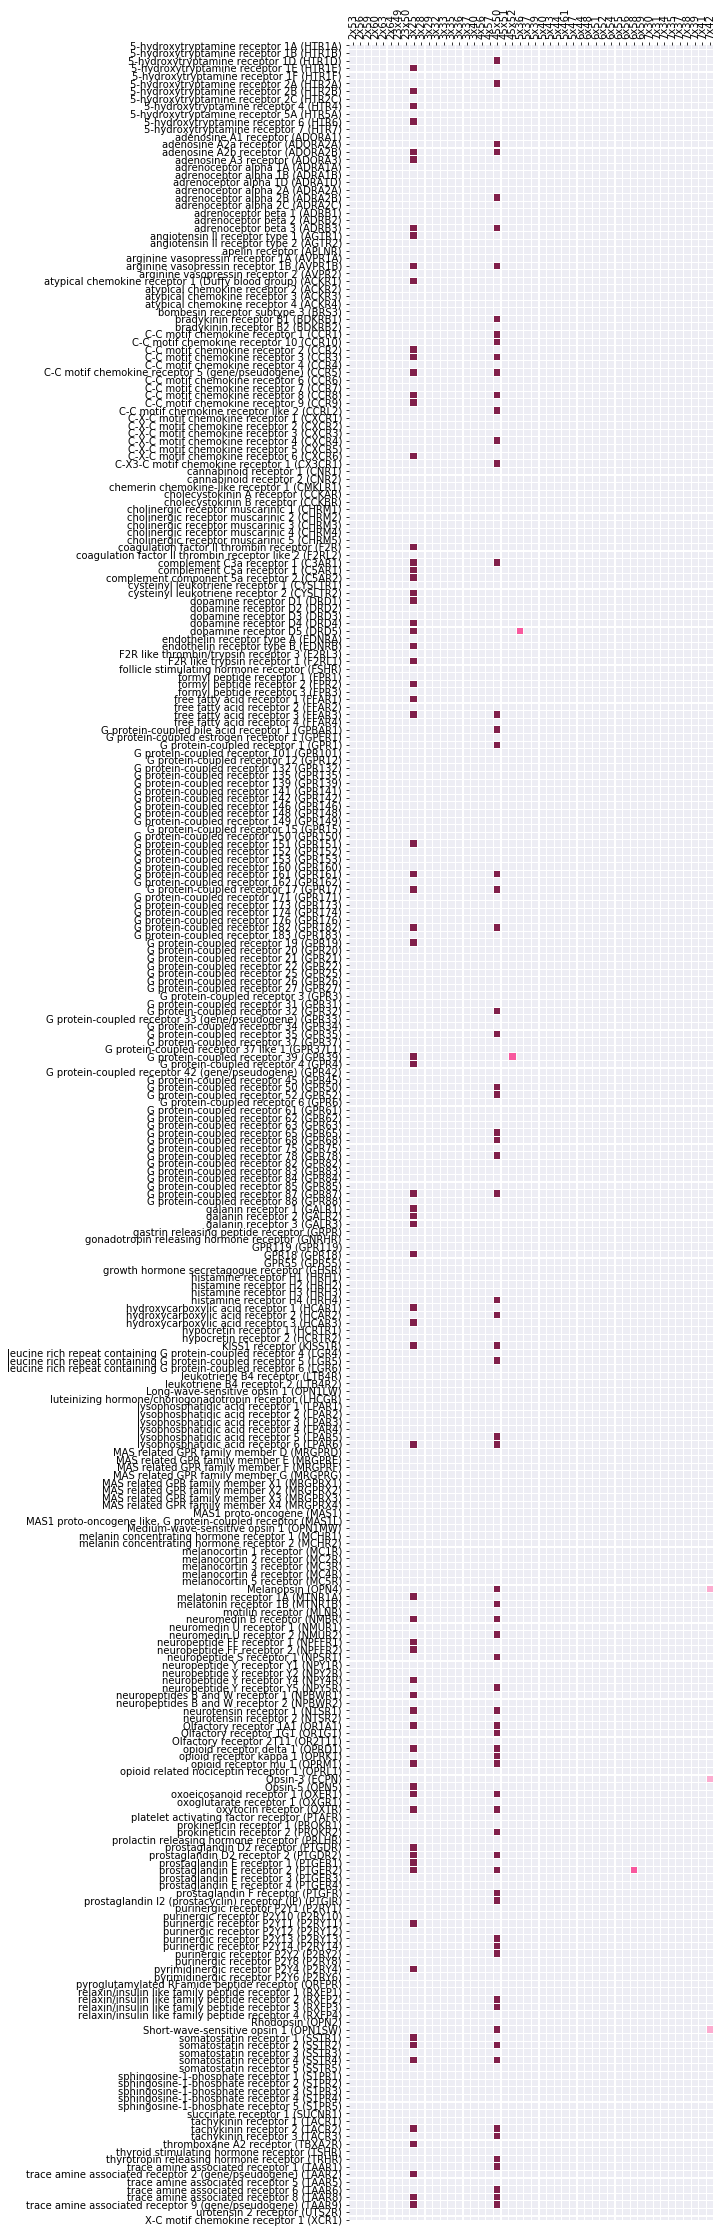

In [22]:
# merge the four df of the ptms in 'gpcr_bspos_ptm_types'
colorsPTMs=anls.fill_in_dataFrame_ptm_all_types(gpcr_bspos_ptm_types,gpcr_bspos_ptm_modRes,gpcr_bspos_ptm_glyco,gpcr_bspos_ptm_lipid,gpcr_bspos_ptm_db,binding_site_gnum)
anls.heatmap_only_ptm_all_types(gpcr_bspos_ptm_types,colorsPTMs)

In [23]:
# heatmap only PTMs by color:

dimension=computeDimensions(binding_site_gnum,df,'PTM')

# dimension=[116, 6]#GPCRs and pos with PTMs




45x50 HTR1D ['yes']
3x25 HTR1E ['yes']
45x50 HTR2A ['yes']
3x25 HTR2B ['yes', 'yes']
3x25 HTR4 ['yes']
3x25 HTR6 ['yes']
45x50 ADORA2A ['yes']
3x25 ADORA2B ['yes']
45x50 ADORA2B ['yes', 'yes']
3x25 ADORA3 ['yes']
45x50 ADRA2B ['yes', 'yes']
3x25 ADRB3 ['yes']
45x50 ADRB3 ['yes']
3x25 AGTR1 ['yes']
3x25 AVPR1B ['yes']
45x50 AVPR1B ['yes']
3x25 ACKR1 ['yes', 'yes']
45x50 BDKRB1 ['yes']
45x50 CCR1 ['yes']
45x50 CCR10 ['yes']
3x25 CCR2 ['yes']
3x25 CCR3 ['yes']
45x50 CCR3 ['yes']
3x25 CCR5 ['yes']
45x50 CCR5 ['yes']
3x25 CCR8 ['yes']
45x50 CCR8 ['yes']
3x25 CCR9 ['yes', 'yes']
45x50 CCRL2 ['yes']
45x50 CXCR4 ['yes']
3x25 CXCR6 ['yes']
45x50 CX3CR1 ['yes']
3x25 F2R ['yes']
3x25 C3AR1 ['yes']
45x50 C3AR1 ['yes']
3x25 C5AR1 ['yes', 'yes']
3x25 C5AR2 ['yes']
3x25 CYSLTR2 ['yes']
3x25 DRD1 ['yes']
3x25 DRD4 ['yes']
3x25 DRD5 ['yes']
5x36 DRD5 ['Yes']
3x25 EDNRB ['yes', 'yes']
3x25 F2RL1 ['yes']
3x25 FPR2 ['yes']
3x25 FFAR1 ['yes']
3x25 FFAR3 ['yes']
45x50 FFAR3 ['yes', 'yes']
45x50 GPBAR1 ['yes

In [24]:
gpcrsPTM=['TAAR9', 'TBXA2R', 'CCR9', 'FFAR3', 'GPR65', 'NPFFR1', 'OR1G1', 'SSTR2', 'GALR2', 'P2RY2', 'ADORA2A', 'P2RY14', 'TACR2', 'CCR3', 'RXFP3', 'NPY4R', 'HCAR3', 'HTR4', 'ECPN', 'HTR6', 'GPR4', 'GALR3', 'BDKRB1', 'GPBAR1', 'GALR1', 'GPR151', 'TAAR8', 'ADORA2B', 'TAAR2', 'AVPR1B', 'OPN5', 'PTGFR', 'PROKR2', 'GPR1', 'SSTR4', 'LPAR5', 'PTGER1', 'HTR1D', 'GPR32', 'CYSLTR2', 'FPR2', 'GPR50', 'OPN4', 'TACR3', 'GPR52', 'LGR5', 'EDNRB', 'NPY5R', 'DRD5', 'NPSR1', 'CCRL2', 'HTR1E', 'FFAR1', 'GPR68', 'OPRD1', 'OPRM1', 'CCR10', 'CX3CR1', 'RXFP2', 'P2RY13', 'TAAR1', 'OPN1SW', 'HRH4', 'OR1A1', 'CXCR4', 'F2RL1', 'GPR182', 'OXTR', 'TRHR', 'ADRB3', 'GPR18', 'CCR1', 'PTGIR', 'MTNR1A', 'ADORA3', 'KISS1R', 'AGTR1', 'HTR2B', 'P2RY4', 'PTGER2', 'GPR87', 'GPR19', 'CCR5', 'PTGDR', 'GPR39', 'OXER1', 'DRD4', 'LPAR6', 'NMBR', 'GPR17', 'MTNR1B', 'C5AR2', 'PTGDR2', 'C5AR1', 'CCR8', 'ACKR1', 'NMUR2', 'P2RY11', 'NPBWR1', 'HTR2A', 'SSTR1', 'HCAR1', 'CCR2', 'F2R', 'DRD1', 'ADRA2B', 'TAAR6', 'NPFFR2', 'OPRK1', 'NTSR1', 'HCAR2', 'GPR78', 'CXCR6', 'C3AR1', 'GPR161', 'GPR35']
PTMpos=['3x25','45x50','45x52','5x36','6x58','7x42']

In [25]:

def fill_in_dataFrame_PTMOnly(dataFrame,dfPTM,listGnum,PTMpos,PTMGpcr,yaxis=all_gpcrs_axes):
    ''' '''
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        print(gpcrname, gpcr)
        for ibspos in listGnum: # iterate over positions
            if ibspos in PTMpos and gpcr in PTMGpcr:
                print('Match',ibspos, gpcr)
                value=dfPTM[ibspos][gpcrname]#0,1,2,3,4
                print(value)
                if value>0:#if PTM   
#                     print(ibspos,gpcr,value)
                    dataFrame[ibspos][gpcr]=value # we will take tha max in case there
#                     print(ibspos, gpcrname,dataFrame[ibspos][gpcr])
    return None

#The df gpcr_bspos_ptm_types, values 0,1,2,3,4 -> noPTM, MR, Glyco, Lipid, DB

PTMOnly=pd.DataFrame(columns=PTMpos,index=gpcrsPTM).fillna(value=0)
fill_in_dataFrame_PTMOnly(PTMOnly, gpcr_bspos_ptm_types, binding_site_gnum,PTMpos,gpcrsPTM)
PTMOnlyClus=anls.cluster_df(PTMOnly)#cluster the dataframe


5-hydroxytryptamine receptor 1A (HTR1A) HTR1A
5-hydroxytryptamine receptor 1B (HTR1B) HTR1B
5-hydroxytryptamine receptor 1D (HTR1D) HTR1D
Match 3x25 HTR1D
0
Match 45x50 HTR1D
4
Match 45x52 HTR1D
0
Match 5x36 HTR1D
0
Match 6x58 HTR1D
0
Match 7x42 HTR1D
0
5-hydroxytryptamine receptor 1E (HTR1E) HTR1E
Match 3x25 HTR1E
4
Match 45x50 HTR1E
0
Match 45x52 HTR1E
0
Match 5x36 HTR1E
0
Match 6x58 HTR1E
0
Match 7x42 HTR1E
0
5-hydroxytryptamine receptor 1F (HTR1F) HTR1F
5-hydroxytryptamine receptor 2A (HTR2A) HTR2A
Match 3x25 HTR2A
0
Match 45x50 HTR2A
4
Match 45x52 HTR2A
0
Match 5x36 HTR2A
0
Match 6x58 HTR2A
0
Match 7x42 HTR2A
0
5-hydroxytryptamine receptor 2B (HTR2B) HTR2B
Match 3x25 HTR2B
4
Match 45x50 HTR2B
0
Match 45x52 HTR2B
0
Match 5x36 HTR2B
0
Match 6x58 HTR2B
0
Match 7x42 HTR2B
0
5-hydroxytryptamine receptor 2C (HTR2C) HTR2C
5-hydroxytryptamine receptor 4 (HTR4) HTR4
Match 3x25 HTR4
4
Match 45x50 HTR4
0
Match 45x52 HTR4
0
Match 5x36 HTR4
0
Match 6x58 HTR4
0
Match 7x42 HTR4
0
5-hydroxytrypta

Match 45x52 GPR39
2
Match 5x36 GPR39
0
Match 6x58 GPR39
0
Match 7x42 GPR39
0
G protein-coupled receptor 4 (GPR4) GPR4
Match 3x25 GPR4
4
Match 45x50 GPR4
0
Match 45x52 GPR4
0
Match 5x36 GPR4
0
Match 6x58 GPR4
0
Match 7x42 GPR4
0
G protein-coupled receptor 42 (gene/pseudogene) (GPR42) GPR42
G protein-coupled receptor 45 (GPR45) GPR45
G protein-coupled receptor 50 (GPR50) GPR50
Match 3x25 GPR50
0
Match 45x50 GPR50
4
Match 45x52 GPR50
0
Match 5x36 GPR50
0
Match 6x58 GPR50
0
Match 7x42 GPR50
0
G protein-coupled receptor 52 (GPR52) GPR52
Match 3x25 GPR52
0
Match 45x50 GPR52
4
Match 45x52 GPR52
0
Match 5x36 GPR52
0
Match 6x58 GPR52
0
Match 7x42 GPR52
0
G protein-coupled receptor 6 (GPR6) GPR6
G protein-coupled receptor 61 (GPR61) GPR61
G protein-coupled receptor 62 (GPR62) GPR62
G protein-coupled receptor 63 (GPR63) GPR63
G protein-coupled receptor 65 (GPR65) GPR65
Match 3x25 GPR65
0
Match 45x50 GPR65
4
Match 45x52 GPR65
0
Match 5x36 GPR65
0
Match 6x58 GPR65
0
Match 7x42 GPR65
0
G protein-cou

Match 3x25 TRHR
0
Match 45x50 TRHR
4
Match 45x52 TRHR
0
Match 5x36 TRHR
0
Match 6x58 TRHR
0
Match 7x42 TRHR
0
trace amine associated receptor 1 (TAAR1) TAAR1
Match 3x25 TAAR1
0
Match 45x50 TAAR1
4
Match 45x52 TAAR1
0
Match 5x36 TAAR1
0
Match 6x58 TAAR1
0
Match 7x42 TAAR1
0
trace amine associated receptor 2 (gene/pseudogene) (TAAR2) TAAR2
Match 3x25 TAAR2
4
Match 45x50 TAAR2
0
Match 45x52 TAAR2
0
Match 5x36 TAAR2
0
Match 6x58 TAAR2
0
Match 7x42 TAAR2
0
trace amine associated receptor 5 (TAAR5) TAAR5
trace amine associated receptor 6 (TAAR6) TAAR6
Match 3x25 TAAR6
0
Match 45x50 TAAR6
4
Match 45x52 TAAR6
0
Match 5x36 TAAR6
0
Match 6x58 TAAR6
0
Match 7x42 TAAR6
0
trace amine associated receptor 8 (TAAR8) TAAR8
Match 3x25 TAAR8
4
Match 45x50 TAAR8
4
Match 45x52 TAAR8
0
Match 5x36 TAAR8
0
Match 6x58 TAAR8
0
Match 7x42 TAAR8
0
trace amine associated receptor 9 (gene/pseudogene) (TAAR9) TAAR9
Match 3x25 TAAR9
4
Match 45x50 TAAR9
4
Match 45x52 TAAR9
0
Match 5x36 TAAR9
0
Match 6x58 TAAR9
0
Match

['#fee7f1', '#fcacd0', '#f8589e', '#801f4a']


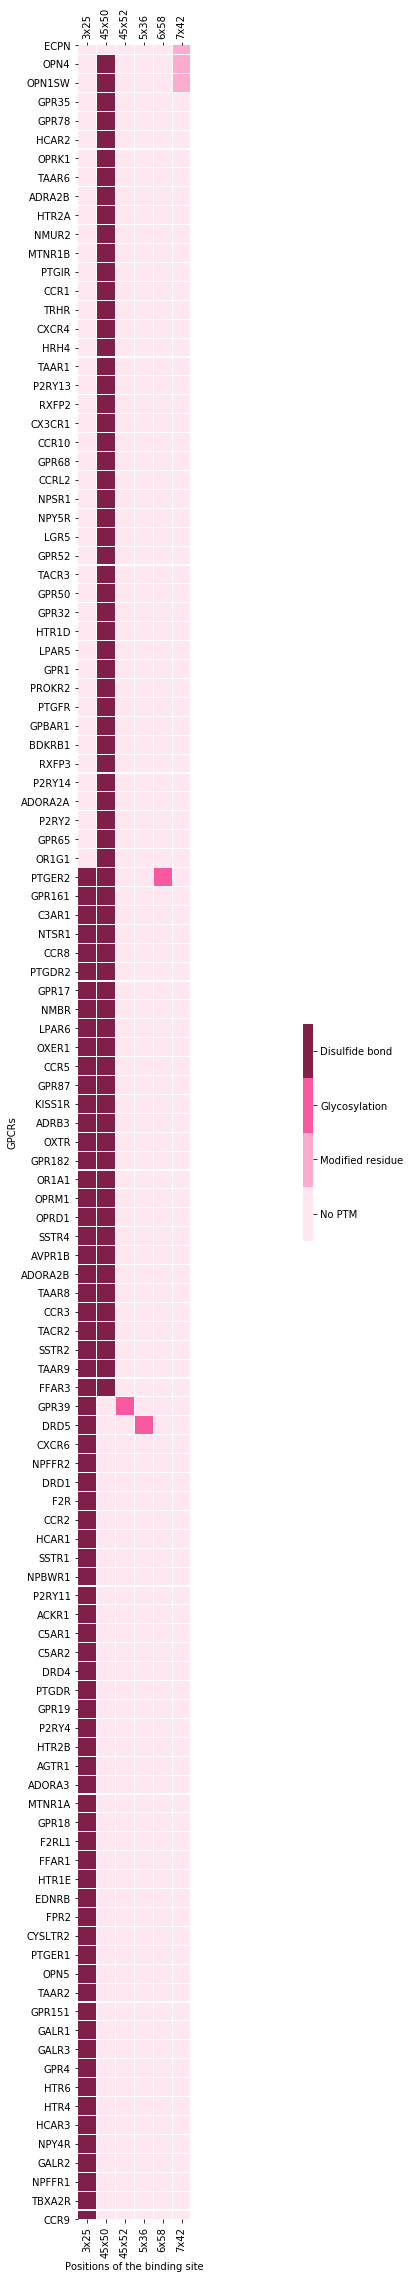

In [26]:
def heatmap_only_ptm_all_types(dataFrame,colors,x=40,y=40):
    '''Plot the data frame than contains the info of the PTM types in different pinks'''    
    colormap=["#fee7f1"]# zero values
    if 'pink1' in colors: #  were cells  with 7 -> 1 now
        colormap.append( "#fcacd0")#pink 1, soft
    if 'pink2' in colors:# there were cells with 8 -> 2
        colormap.append( "#f8589e")# pink 2
    if 'pink3' in colors: # there were cells with 9 -> 3
        colormap.append( "#d00d63")#pink 3 
    if 'pink4' in colors: # there were cells with 10 -> 4
        colormap.append( "#801f4a")#pink dark
    print(colormap)
    fig, ax = plt.subplots(figsize=(x,y))
    # no ptm  modRes  glyco   lipid   db
    # 0,         1,     2,      3,    4
    # white,  pink1, pink2,  pink3, pink4
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=True,square=True,xticklabels=True, yticklabels=True,ax=ax, cbar_kws={"shrink": .1})
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax2.collections[0].colorbar
    colorbar.set_ticks([0.5,1.5,2.5,3.5])
    colorbar.set_ticklabels(['No PTM','Modified residue', 'Glycosylation', 'Disulfide bond'])
    
    ax2.set(xlabel='Positions of the binding site', ylabel='GPCRs')
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.xticks(rotation=90) 
    plt.show()
    return None
heatmap_only_ptm_all_types(PTMOnlyClus,colorsPTMs)
# PTM/heatmapOnlyPTM.png

We can see that the majority of the PTMs are Disulfide Bonds in positions: 3x25 and 45x50. In those positions a Cys is supposed to be forming a disulfide bond with another one to fix the extracellular loops of the GPCRs, but this could be damaged by a variant. On the other hand there are two '7', Modified Residues (very soft pink), and, finally, three '8', Glycosylations. We can see it in the vertiacal sum:

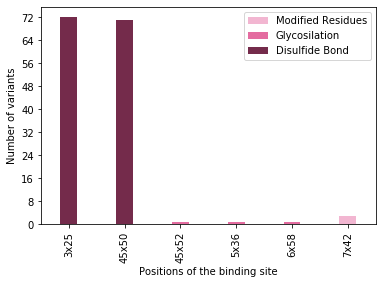

In [27]:
# vertical sum with the different PTMs
from matplotlib.ticker import MaxNLocator
def heatmap_vert_sum_ptms(dataFrame, listGnum, dbs=True):
    '''Horizontal barplot, sum each PTM type and plot them in different pinks'''
    gpcr_pos_count_bybs_all=dict(zip(listGnum,[0]*len(listGnum))) # DBs
    gpcr_pos_count_bybs_modRes=dict(zip(listGnum,[0]*len(listGnum))) # modRes
    gpcr_pos_count_bybs_glyco=dict(zip(listGnum,[0]*len(listGnum))) # glyco
    gpcr_pos_count_bybs_lipid=dict(zip(listGnum,[0]*len(listGnum))) # lipid

    for pos in gpcr_pos_count_bybs_all.keys():
        count_all=len([varval for varval in dataFrame[pos].values if varval==4 ])
        count_modRes=len([varval for varval in dataFrame[pos].values if varval==1])
        count_glyco=len([varval for varval in dataFrame[pos].values if varval==2])
        count_lipid=len([varval for varval in dataFrame[pos].values if varval==3])
        # store sums in the dictionaries position:sum of PTMs
        gpcr_pos_count_bybs_all[pos]=count_all
        gpcr_pos_count_bybs_modRes[pos]=count_modRes
        gpcr_pos_count_bybs_glyco[pos]=count_glyco
        gpcr_pos_count_bybs_lipid[pos]=count_lipid
    
    axisText='Positions of the binding site'
    # build dataframes
    gpcr_pos_count_bybs_all_df=pd.DataFrame(list(gpcr_pos_count_bybs_all.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_modRes_df=pd.DataFrame(list(gpcr_pos_count_bybs_modRes.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_glyco_df=pd.DataFrame(list(gpcr_pos_count_bybs_glyco.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_lipid_df=pd.DataFrame(list(gpcr_pos_count_bybs_lipid.items()),
                          columns=[axisText,'Count'])    
    
    # representation upwards
    fig, ax = plt.subplots(figsize=(6,4))


    axB = sns.barplot(data=gpcr_pos_count_bybs_modRes_df , y="Count",x=axisText,color="#fcacd0",label="Modified Residues",ax=ax)
    #axB.get_xaxis().set_visible(False)
    axB.set_xticklabels(labels=listGnum , rotation=90)
    axB.yaxis.set_label_text("Number of variants")
    anls.change_width_v(axB, 0.3)
    
    axB = sns.barplot(data=gpcr_pos_count_bybs_glyco_df , y="Count",x=axisText,color="#f8589e",label="Glycosilation",ax=ax)
    #axB.get_xaxis().set_visible(False)
    axB.yaxis.set_label_text("Number of variants")
    anls.change_width_v(axB, 0.3)
    
    if dbs:
        axB = sns.barplot(data=gpcr_pos_count_bybs_all_df, y="Count",x=axisText,color="#801f4a",label="Disulfide Bond",ax=ax)
        axB.set_xticklabels(labels=listGnum , rotation=90)
        #axB.get_xaxis().set_visible(False)
        axB.yaxis.set_label_text("Number of variants")
        #axB.invert_yaxis()
        anls.change_width_v(axB, 0.3)
    
    axB.yaxis.set_major_locator(MaxNLocator(integer=True)) # only integers in the y axis
    plt.legend()
    plt.show()
#     plt.savefig("/home/martalo/Documentos/TFM/GPCR_variants/Results/Intracel_Binding_site/ibs_count_positions.png")
    return None


# False as 3rd argument to avoid the max pics of the DB in the BS. 
# True as 4th to visualize the barplot downwards
heatmap_vert_sum_ptms(gpcr_bspos_ptm_types,PTMpos)
#PTM/barplotPTM.png

In [28]:
# vertical sum with the different PTMs

# False as 3rd argument to avoid the max pics of the DB in the BS. 
# True as 4th to visualize the barplot downwards
# anls.heatmap_vert_sum_ptms(gpcr_bspos_ptm_types,binding_site_gnum,False)

## 4. 'Total' analysis (classA): score, disease, PTM
- If score 2: RED -> 2
- If score 1: ORANGE -> 1
- IF score 0: PALE -> 0
- If no-score: WHITE -> 3 
- If score 2 + disease related: color BLUE -> cell 4
- If score 2 + PTM: color PINK -> cell 5
- If score 2 + disease related + PTM: color BLACK -> cell 6

In [29]:
gpcr_bspos_total=anls.build_dataFrame(binding_site_gnum,0)
colorsToHeatmap=anls.fill_in_dataFrame_total(gpcr_bspos_total,gpcr_bspos,gpcr_bspos_dis,gpcr_bspos_ptm,binding_site_gnum)
# anls.heatmap_only_total(gpcr_bspos_total, colorsToHeatmap)

There is a black cell: related with a disease and in a PTM position, in receptor TAAR1 position 45x50 (Disulfide Bond PTM). It will be analyzed after clustering. 

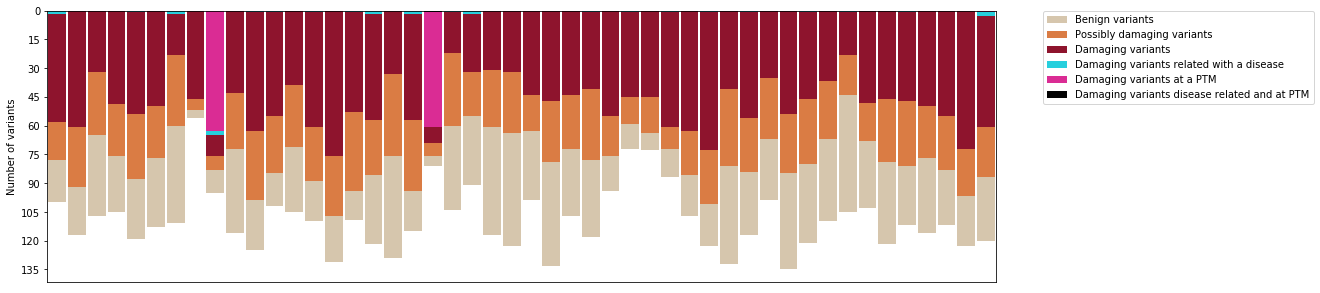

In [30]:

# heatmap_vert_sum_mixed_total_allColors(gpcr_bspos_total,binding_site_gnum,True)
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_bspos_total,binding_site_gnum,True,True) # legendOut, downwards
#classA/vertical.png

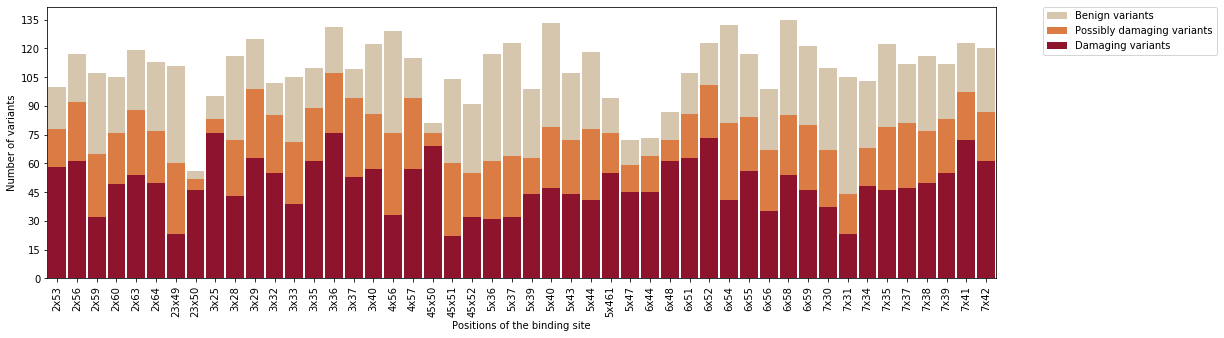

In [62]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_bspos_total,binding_site_gnum,True,False, True,True, True)
#classA/verticalUP.png

We can see that now we have 63 DBs in position 3x25 so 69-61=8 variants that were at PTM positions were not damaging (score different than 2). Also, in the last position, there were two variants at PTMs ModRes, among them just one was damaging. The three glycosylations were not damaging either.

## 5. Only aminergic: score, disease, PTM

In [32]:
families=['5-Hydroxytryptamine receptors', 'Acetylcholine receptors (muscarinic)', 'Adrenoceptors', 'Dopamine receptors', 'Histamine receptors','Trace amine receptor']
aminergicSet=set()
aminergic=[]
aminergicLong=[]

dataFile="myprot_list_struc.csv"
with open(os.path.join(resultspath,dataFile),"r") as myvarfile:
    myvarread = csv.reader(myvarfile, delimiter=';') 
    for myrow in myvarread:
        score=0
        if myrow[0]=='Family':
            continue
        else:
            if myrow[0] in families:
                gpcr=myrow[1]+' ('+myrow[2]+')'
                aminergicSet.add(myrow[2])
                aminergicLong.append(gpcr)
myvarfile.close()    
aminergic=list(aminergicSet)     
# delete the ones without variant info: 
aminergicLong.remove('5-hydroxytryptamine receptor 5B, pseudogene (HTR5BP)')
len(aminergic)
# print(aminergicLong)

37

In [33]:
gpcr_bspos_total_amin=anls.build_dataFrame(binding_site_gnum,0,aminergicLong)
anls.filter_aminergic(gpcr_bspos_total,gpcr_bspos_total_amin,aminergic,binding_site_gnum)


,2x53,2x56,2x59,2x60,2x63,2x64,23x49,23x50,3x25,3x28,...,6x59,7x30,7x31,7x34,7x35,7x37,7x38,7x39,7x41,7x42
5-hydroxytryptamine receptor 1A (HTR1A),3,3,1,3,3,3,3,3,3,3,...,2,1,0,0,3,3,0,3,2,2
5-hydroxytryptamine receptor 1B (HTR1B),3,3,1,1,2,2,3,2,3,3,...,3,0,3,3,3,3,3,3,3,2
5-hydroxytryptamine receptor 1D (HTR1D),3,2,3,3,3,3,3,3,3,3,...,3,3,0,3,3,3,2,3,2,2
5-hydroxytryptamine receptor 1E (HTR1E),3,2,3,3,3,3,1,3,5,3,...,2,3,3,3,1,3,2,3,3,3
5-hydroxytryptamine receptor 1F (HTR1F),2,3,3,2,2,3,0,3,3,3,...,3,3,3,0,3,3,3,3,2,2
5-hydroxytryptamine receptor 2A (HTR2A),3,2,2,3,3,3,1,2,3,3,...,2,1,0,2,1,3,3,2,3,3
5-hydroxytryptamine receptor 2B (HTR2B),2,3,2,3,3,3,0,2,5,3,...,3,3,3,3,0,3,2,2,3,3
5-hydroxytryptamine receptor 2C (HTR2C),3,3,3,3,3,1,0,3,3,3,...,3,3,3,3,3,3,3,3,3,3
5-hydroxytryptamine receptor 4 (HTR4),2,3,3,0,3,3,0,2,5,1,...,2,3,0,3,3,3,3,2,2,2
5-hydroxytryptamine receptor 5A (HTR5A),2,3,3,2,3,2,2,3,3,2,...,2,2,1,3,2,3,3,3,2,3


In [34]:
def heatmap_only_total_BS(dataFrame,colors,listGnum,amin=False,x=40,y=40):
    '''Plot the data frame than contains the info of the score, diseases and PTM.
    Add True to change the y axis label to aminergic'''    
    colormap=["#DDC8A6","#F3752B","#A20021", "#EDEDF4","#09E9FB","#F70F9A", '#030303']
    print("Benign: #DDC8A6 -> crudo")
    print("Pos Dam: #F3752B -> Orange")
    print("Dam: #A20021 -> Red")
    print("No data: #EDEDF4 -> white")
    print("Dam + Dis: #09E9FB -> blue")
    print("Dam + PTM: #F70F9A -> pink")
    print("Dam + Dis + PTM: #030303 -> black")
    
    print(colormap)
    fig, ax = plt.subplots(figsize=(x,y))
    # bening, poss, dam,nodata, dis,   ptm, dis-ptm
    # 0,      1,     2,    3,    4,   5,      6
    # pale, orange, red, white, blue, pink, black
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
    ax2.xaxis.set_ticks_position('top')
    axisText=anls.defineRegion(listGnum)
    if amin:
        ax.set(xlabel=axisText, ylabel='Aminergic GPCRs')
    else: 
        ax.set(xlabel=axisText,ylabel='Class A GPCRs')
    
    ax2.xaxis.set_label_position('top')
    plt.xticks(rotation=90) 
    plt.show()
    return None
# heatmap_only_total_BS(gpcr_bspos_total_amin, colorsToHeatmap,binding_site_gnum,True,11,11)

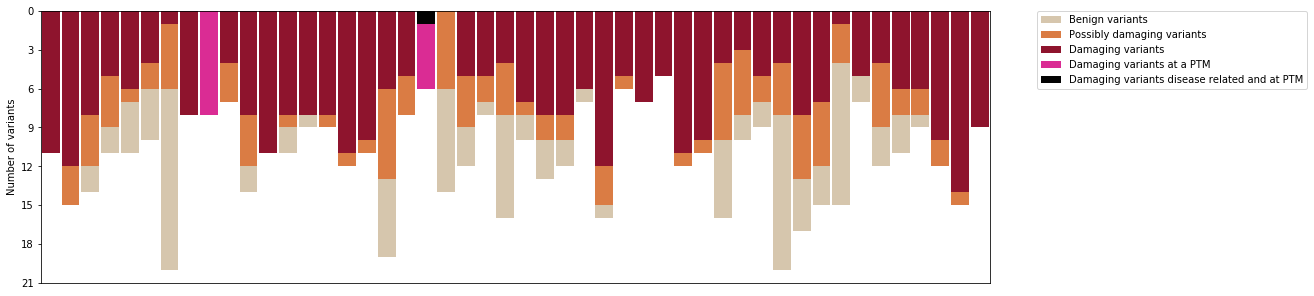

In [35]:
def heatmap_vert_sum_mixed_total_allColors(dataFrame, listGnum, legendOut=False ,downwards=False, notBlue=False, notPink=False,notBlack=False, barWidth=0.9):
    '''Plot the vertical sum of the variants (for each position) differenciating the
    benign, pos dam, only dam, dis, PTM and disPTM in different colors. 
    Legend can be outside the plot.
    The barplot can go downwards.'''
    gpcr_pos_count_bybs_all=dict(zip(listGnum,[0]*len(listGnum))) # 0,1,2,4,5,6 -> benign
    gpcr_pos_count_bybs_pos_dam=dict(zip(listGnum,[0]*len(listGnum))) # 1,2,4,5,6 -> poss dam    
    gpcr_pos_count_bybs_damaging=dict(zip(listGnum,[0]*len(listGnum))) # 2,4,5,6 -> dam 
    
    gpcr_pos_count_bybs_dis_join_ptm_join_dis_ptm=dict(zip(listGnum,[0]*len(listGnum))) # 4,5,6
    gpcr_pos_count_bybs_ptm_join_dis_ptm=dict(zip(listGnum,[0]*len(listGnum)))#5,6
    gpcr_pos_count_bybs_dis_ptm=dict(zip(listGnum,[0]*len(listGnum)))#6
    
    pos_dam=[1,2,4,5,6]
    dam=[2,4,5,6]
    damDisPTMjoin=[4,5,6]
    damPTMjoin=[5,6]
    for pos in gpcr_pos_count_bybs_all.keys():
        # all: all variants with score different than 3 (all variants with prediction)
        count_all=len([varval for varval in dataFrame[pos].values if varval!=3 ])# 0,1,2,4,5,6
        # bening: 
        count_pos_dam=len([varval for varval in dataFrame[pos].values if varval in pos_dam ])# 1,2,4,5,6
        # damaging 
        count_damaging=len([varval for varval in dataFrame[pos].values if varval in dam]) # 2,4,5,6
        # damaging + dis (4) and dam + PTM (5) and dam +PTM + dis (6)
        count_dis_join_ptm_join_dis_ptm=len([varval for varval in dataFrame[pos].values if varval in damDisPTMjoin ])
        # damaging + PTM (5) and dam + PTM + dis (6)
        count_join_dis_ptm=len([varval for varval in dataFrame[pos].values if varval in damPTMjoin ])
        # dam + PTM + dis (6)
        count_dis_ptm=len([varval for varval in dataFrame[pos].values if varval==6 ])
        
        gpcr_pos_count_bybs_all[pos]=count_all
        gpcr_pos_count_bybs_pos_dam[pos]=count_pos_dam
        gpcr_pos_count_bybs_damaging[pos]=count_damaging
        
        gpcr_pos_count_bybs_dis_join_ptm_join_dis_ptm[pos]=count_dis_join_ptm_join_dis_ptm
        gpcr_pos_count_bybs_ptm_join_dis_ptm[pos]=count_join_dis_ptm
        gpcr_pos_count_bybs_dis_ptm[pos]=count_dis_ptm
    
    axisText=defineRegion(listGnum)
    gpcr_pos_count_bybs_all_df=pd.DataFrame(list(gpcr_pos_count_bybs_all.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_pos_damaging_df=pd.DataFrame(list(gpcr_pos_count_bybs_pos_dam.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_damaging_df=pd.DataFrame(list(gpcr_pos_count_bybs_damaging.items()),
                          columns=[axisText,'Count'])
    
    gpcr_pos_count_bybs_dis_ptm_join_df=pd.DataFrame(list(gpcr_pos_count_bybs_dis_join_ptm_join_dis_ptm.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_ptm_join_df=pd.DataFrame(list(gpcr_pos_count_bybs_ptm_join_dis_ptm.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_dis_ptm_df=pd.DataFrame(list(gpcr_pos_count_bybs_dis_ptm.items()),
                          columns=[axisText,'Count'])
    
    xWidth=5
    # Benign -> 0
    fig, ax = plt.subplots(figsize=( xWidth,3))
    axB = sns.barplot(data=gpcr_pos_count_bybs_all_df , y="Count",x=axisText,color="#DDC8A6",label="Benign variants",ax=ax)
    axB.set_xticklabels(labels=dataFrame.columns , rotation=90)
    axB.yaxis.set_label_text("Number of variants")
    if downwards:
        axB.invert_yaxis()
        axB.get_xaxis().set_visible(False)
    anls.change_width_v(axB, barWidth)
    
    # Poss damaging -> 1
    axB = sns.barplot(data=gpcr_pos_count_bybs_pos_damaging_df , y="Count",x=axisText,color="#F3752B",label="Possibly damaging variants",ax=ax)
    #axB.get_xaxis().set_visible(False)
    axB.yaxis.set_label_text("Number of variants")
    anls.change_width_v(axB, barWidth)

    # Damaging (2,4,5,6) -> 'only damaging' 2 (red)
    axB = sns.barplot(data=gpcr_pos_count_bybs_damaging_df , y="Count",x=axisText,color="#A20021",label="Damaging variants",ax=ax)
    #axB.get_xaxis().set_visible(False)
    axB.yaxis.set_label_text("Number of variants")
    anls.change_width_v(axB, barWidth)
    
    # Damaging PTM Dis and join DisPTM (4,5,6) -> damaging + disease, score 4 (blue)
    if not notBlue:# there are not blue dots
        axB = sns.barplot(data=gpcr_pos_count_bybs_dis_ptm_join_df , y="Count",x=axisText,color="#09E9FB",label="Damaging variants related with a disease",ax=ax)
        #axB.get_xaxis().set_visible(False)
        axB.yaxis.set_label_text("Number of variants")
        anls.change_width_v(axB, barWidth)
    
    # Damaging and join DisPTM (5,6)  -> damaging + PTM, score 5 (pink)
    if not notPink:
        axB = sns.barplot(data=gpcr_pos_count_bybs_ptm_join_df , y="Count",x=axisText,color="#F70F9A",label="Damaging variants at a PTM",ax=ax)
        #axB.get_xaxis().set_visible(False)
        axB.yaxis.set_label_text("Number of variants")
        anls.change_width_v(axB, barWidth)
    
    #damaging + PTM + Dis, score 6 black
    if not notBlack:
        axB = sns.barplot(data=gpcr_pos_count_bybs_dis_ptm_df , y="Count",x=axisText,color="#030303",label="Damaging variants disease related and at PTM",ax=ax)
        #axB.get_xaxis().set_visible(False)
        axB.yaxis.set_label_text("Number of variants")
        anls.change_width_v(axB, barWidth)
    
    axB.yaxis.set_major_locator(MaxNLocator(integer=True)) # only integers in the y axis
    
    
    if legendOut:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend()
    plt.show()
#     plt.savefig("/home/martalo/Documentos/TFM/GPCR_variants/Results/Intracel_Binding_site/ibs_count_positions.png")
    return None
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_bspos_total_amin,binding_site_gnum,True,True,True) # legendOut, downwards, notBlue
#amin/vertical.png

Remember that the colors and var types are added (not the total heigh of the bar). That means that in pos 2x56 for example, there are 10 damaging and only 2 possibly damaging (not 12).

## 5. Clustering
### 5.1 Clustering Class A, heatmap and horizontal sum

In [36]:
gpcr_bspos=anls.cluster_df(gpcr_bspos)
gpcr_bspos_count=dict(zip(all_gpcrs_axes,[0]*len(all_gpcrs_axes)))
gpcr_bspos_count_df=pd.DataFrame(list(gpcr_bspos_count.items()),
                      columns=['GPCR','Count'])
# build dictionaries and df with only damaging:
(gpcr_bspos_count_damaging_df,df_damaging)=anls.get_count_data(2,gpcr_bspos)#damaging
# and only possibly damaging and damaging
(gpcr_bspos_count_all_df,df_all)=anls.get_count_data(1,gpcr_bspos)# possibly damaging and damaging

sorter=gpcr_bspos.index
gpcr_bspos_count_df=anls.order_df_by_sorterlist(sorter,gpcr_bspos_count_df)
gpcr_bspos_count_all_df=anls.order_df_by_sorterlist(sorter,gpcr_bspos_count_all_df)
gpcr_bspos_count_damaging_df=anls.order_df_by_sorterlist(sorter,gpcr_bspos_count_damaging_df)

# visualize the clustered heatmap and horizontal barplots without dis, ptm info
# anls.heatmap_only(gpcr_bspos)
# heatmap_horizontal_sum_mixed_cluster(gpcr_bspos, gpcr_bspos_count_all_df,gpcr_bspos_count_damaging_df )

In [37]:
# build new dataframe clusterized and with dis/ptm info
gpcr_bspos_total_clus=pd.DataFrame(index=gpcr_bspos.index, columns=gpcr_bspos.columns).fillna(value=0)
colorsToHeatmap=anls.fill_in_dataFrame_total(gpcr_bspos_total_clus,gpcr_bspos,gpcr_bspos_dis,gpcr_bspos_ptm,binding_site_gnum)

['#DDC8A6', '#F3752B', '#A20021', '#EDEDF4', '#09E9FB', '#F70F9A', '#030303']


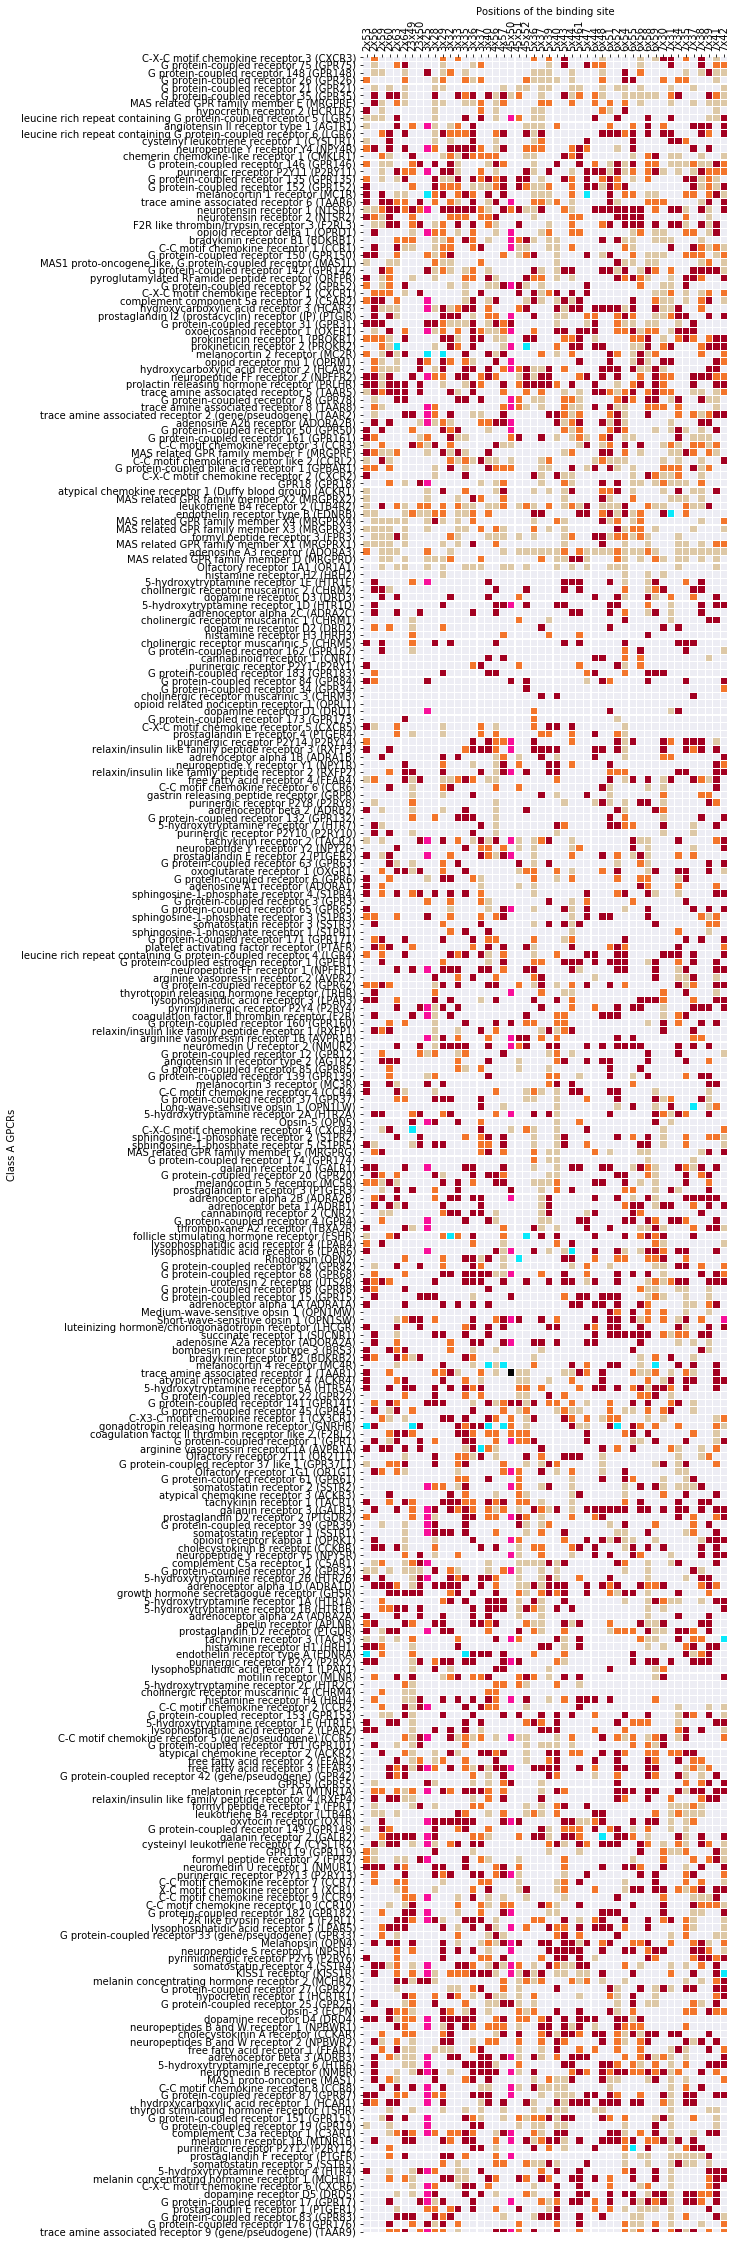

In [38]:
# def heatmap_only_total(dataFrame,colors,x=40,y=40):
#     '''Plot the data frame than contains the info of the score, diseases and PTM'''    
#     colormap=["#DDC8A6","#F3752B","#A20021", "#EDEDF4"]
#     if 'blue' in colors: # there are cells with 10
#         colormap.append( "#09E9FB")
#     if 'pink' in colors:# there are cells with 20
#         colormap.append( "#F70F9A")
#     if 'black' in colors: # there are cells with 30
#         colormap.append( "#030303")
#     print(colormap)
#     fig, ax = plt.subplots(figsize=(x,y))
#     # bening, poss, dam,nodata, dis,   ptm, dis-ptm
#     # 0,      1,     2,    3,    4,   5,      6
#     # pale, orange, red, white, blue, pink, black
#     ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
#     ax2.xaxis.set_ticks_position('top')
#     ax2.xaxis.set_label_position('top')
#     axisText='Positions of the binding site'
#     ax2.xaxis.set_label_text(axisText)
#     ax2.yaxis.set_label_text("Class A GPCRs")
    
#     plt.xticks(rotation=90) 
#     plt.show()
#     return None
anls.heatmap_only_total(gpcr_bspos_total_clus,'Positions of the binding site',"Class A GPCRs", colorsToHeatmap)
# classA/heatmap.png

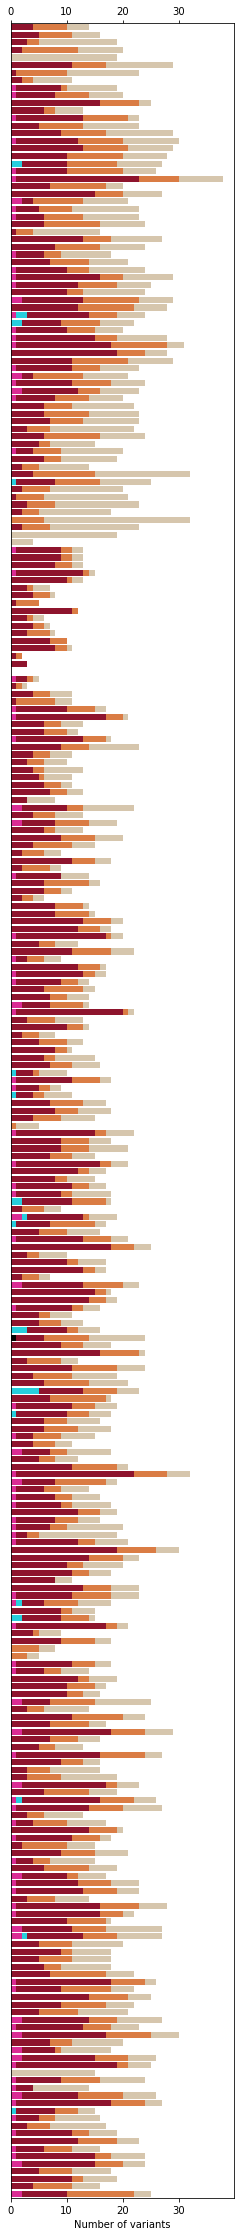

In [39]:
# horizontal barplot class A clusterized  
def get_counts(dataFrame, varType, yaxes=all_gpcrs_axes):
    ''' Build a dictionary and a data frame with the values that are in the 'range'
    of the corresponding varType, coming from the orignal dataframe'''
    # select the correct scores for each varType
    scores={'benign':[0,1,2,4,5,6],'posDam':[1,2,4,5,6],'dam':[2,4,5,6], 'disPTMjoin':[4,5,6], 'PTMjoin':[5,6], 'join':[6]}
    myList=scores[varType]
    #build dict with values as 0
    gpcr_pos_count_sel=dict(zip(yaxes,[0]*len(yaxes)))
    for gpcridx in gpcr_pos_count_sel.keys():# iterate over the GPCR names
        # count how many times the cells has a valueof the correct list 
        count=len([varval for varval in dataFrame.loc[gpcridx].values if varval in myList])
        gpcr_pos_count_sel[gpcridx]=count
        
    #build new data frame
    gpcr_pos_count_sel_df=pd.DataFrame(list(gpcr_pos_count_sel.items()),
                          columns=['GPCR','Count'])

    df_sel=pd.DataFrame.from_dict(gpcr_pos_count_sel,orient="index").T
    return (gpcr_pos_count_sel_df,df_sel)

def heatmap_total_horizontal_sum_mixed_cluster(dataFrame, small=False, ptm=False, disPTM=False, legendOut=False):
    ''' Build the horizontal barplot, sum for each GPCR, with the disease and PTM info.
    Add True as 2nd parameter if the heatmap will be for only aminergic (smaller df).
    Add True as 3rd parameter if there are ptm values to be displayed (pink).
    Add True as 4th parameter if there are Dis + ptm values to be displayed (black).
    Add True as 5th parameter if you want the legend out of the plot'''
    # build dictionaries and df with only damaging:
    rows=list(dataFrame.index.values)
    (gpcr_ibspos_count_ben_df,df_ben)=get_counts(dataFrame,'benign',rows)#bening
    (gpcr_ibspos_count_damaging_df,df_damaging)=get_counts(dataFrame,'dam',rows)#damaging
    # and only possibly damaging and damaging
    (gpcr_ibspos_count_all_df,df_all)=get_counts(dataFrame,'posDam',rows)# possibly damaging and damaging
    
    # dam+dis
    (gpcr_ibspos_count_dis_df,df_dis)=get_counts(dataFrame,'disPTMjoin',rows)#damaging+disease
    # dam+ptm
    (gpcr_ibspos_count_ptm_df,df_ptm)=get_counts(dataFrame,'PTMjoin',rows)#damaging+ptm
    # dam+dis+ptm
    (gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)=get_counts(dataFrame,'join',rows)#damaging+dis+ptm

    abundance_dist_damaging_df=anls.get_count_dist(gpcr_ibspos_count_damaging_df,df_damaging)
    abundance_dist_all_df=anls.get_count_dist(gpcr_ibspos_count_all_df,df_all)
    abundance_dist_bening_df=anls.get_count_dist(gpcr_ibspos_count_ben_df,df_ben)
    
    abundance_dist_dis_df=anls.get_count_dist(gpcr_ibspos_count_dis_df,df_dis)
    abundance_dist_ptm_df=anls.get_count_dist(gpcr_ibspos_count_ptm_df,df_ptm)
    abundance_dist_dis_ptm_df=anls.get_count_dist(gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)
    
    #reprentation of both dataframes in a barplot
    grid = plt.GridSpec(1, 1)
    if not small:
        fig, ax = plt.subplots(figsize=(4,40))
    else: 
        fig, ax = plt.subplots(figsize=(6,11))
    #benign
    ax1=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_ben_df , x="Count",y="GPCR",color="#DDC8A6",label="Benign variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # pos dam
    ax2=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#F3752B",label="Possibly-damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # dam
    ax3=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_damaging_df , x="Count",y="GPCR",color="#A20021",label="Damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    # dis
    ax4=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_dis_df , x="Count",y="GPCR",color="#09E9FB",label="Damaging variants related with diseases")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    
    # PTM
    if ptm:
        ax5=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_ptm_df , x="Count",y="GPCR",color="#F70F9A",label="Damaging variants at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    # PTM+Dis    
    if disPTM:
        ax6=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_ptm_df , x="Count",y="GPCR",color="#030303",label="Damaging variants disease related at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
#     if legendOut:
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     else:
#         plt.legend()
        
    axB.get_yaxis().set_visible(False) # not visible
    plt.show()
    return None

heatmap_total_horizontal_sum_mixed_cluster(gpcr_bspos_total_clus,False,True,True,True)#non-small, PTMs(pink), PTM+Dis(black), legend out
#classA/horizontal.png

['#DDC8A6', '#F3752B', '#A20021', '#EDEDF4', '#09E9FB', '#F70F9A', '#030303']


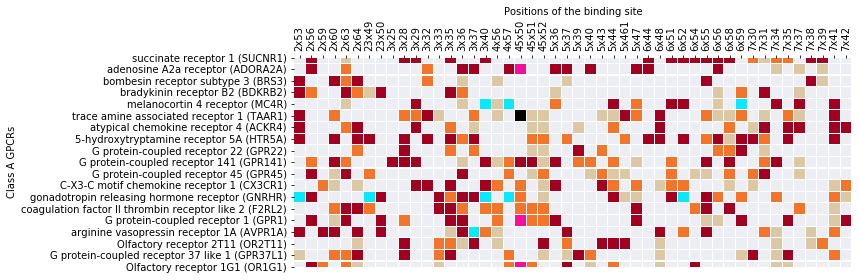

In [40]:
# Small part of the heatmap
gpcr_bspos_total_clus_cut = pd.DataFrame(gpcr_bspos_total_clus)[-119:-100].copy(deep=True)

def heatmap_only_total_cut(dataFrame,colors,axisText,x=40,y=40):
    
    '''Plot the data frame than contains the info of the score, diseases and PTM'''    
    colormap=["#DDC8A6","#F3752B","#A20021", "#EDEDF4"]
    if 'blue' in colors: # there are cells with 10
        colormap.append( "#09E9FB")
    if 'pink' in colors:# there are cells with 20
        colormap.append( "#F70F9A")
    if 'black' in colors: # there are cells with 30
        colormap.append( "#030303")
    print(colormap)
    fig, ax = plt.subplots(figsize=(x,y))
    # bening, poss, dam,nodata, dis,   ptm, dis-ptm
    # 0,      1,     2,    3,    4,   5,      6
    # pale, orange, red, white, blue, pink, black
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
    ax2.xaxis.set_ticks_position('top')
    ax.set(xlabel=axisText,ylabel='Class A GPCRs')    
    ax2.xaxis.set_label_position('top')
    plt.xticks(rotation=90)
    return None
    
heatmap_only_total_cut(gpcr_bspos_total_clus_cut, colorsToHeatmap, 'Positions of the binding site',10,10)
# classA/heatmapZoom.png

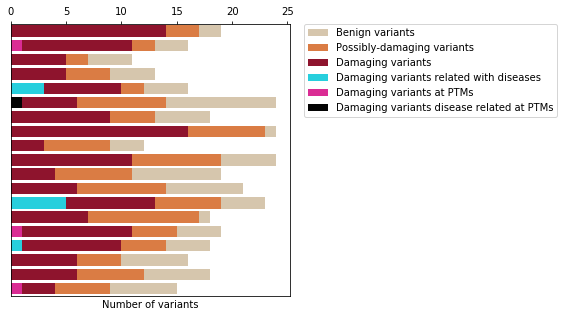

In [41]:
def heatmap_total_horizontal_sum_mixed_cluster_cut(dataFrame, x,y, small=False, dis=False, ptm=False, disPTM=False, legendOut=False, yText=False):
    ''' Build the horizontal barplot, sum for each GPCR, with the disease and PTM info.
    Add True as 2nd parameter if the heatmap will be for only aminergic (smaller df).
    Add True as 3rd parameter if there are ptm values to be displayed (pink).
    Add True as 4th parameter if there are Dis + ptm values to be displayed (black).
    Add True as 5th parameter if you want the legend out of the plot
    dd True as 6th parameter if you want to hide the ylabels'''
    # build dictionaries and df with only damaging:
    rows=list(dataFrame.index.values)
    (gpcr_ibspos_count_ben_df,df_ben)=anls.get_counts(dataFrame,'benign',rows)#bening
    (gpcr_ibspos_count_damaging_df,df_damaging)=anls.get_counts(dataFrame,'dam',rows)#damaging
    # and only possibly damaging and damaging
    (gpcr_ibspos_count_all_df,df_all)=anls.get_counts(dataFrame,'posDam',rows)# possibly damaging and damaging
    
    # dam+dis
    (gpcr_ibspos_count_dis_df,df_dis)=anls.get_counts(dataFrame,'disPTMjoin',rows)#damaging+disease
    # dam+ptm
    (gpcr_ibspos_count_ptm_df,df_ptm)=anls.get_counts(dataFrame,'PTMjoin',rows)#damaging+ptm
    # dam+dis+ptm
    (gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)=anls.get_counts(dataFrame,'join',rows)#damaging+dis+ptm

    abundance_dist_damaging_df=anls.get_count_dist(gpcr_ibspos_count_damaging_df,df_damaging)
    abundance_dist_all_df=anls.get_count_dist(gpcr_ibspos_count_all_df,df_all)
    abundance_dist_bening_df=anls.get_count_dist(gpcr_ibspos_count_ben_df,df_ben)
    
    abundance_dist_dis_df=anls.get_count_dist(gpcr_ibspos_count_dis_df,df_dis)
    abundance_dist_ptm_df=anls.get_count_dist(gpcr_ibspos_count_ptm_df,df_ptm)
    abundance_dist_dis_ptm_df=anls.get_count_dist(gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)
    
    #reprentation of both dataframes in a barplot
    grid = plt.GridSpec(1, 1)
    fig, ax = plt.subplots(figsize=(x,y)) 
    #benign
    ax1=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_ben_df , x="Count",y="GPCR",color="#DDC8A6",label="Benign variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    if not yText:
        axB.get_yaxis().set_visible(False) # not visible
        
    # pos dam
    ax2=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#F3752B",label="Possibly-damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # dam
    ax3=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_damaging_df , x="Count",y="GPCR",color="#A20021",label="Damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    # dis
    if dis:
        ax4=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_df , x="Count",y="GPCR",color="#09E9FB",label="Damaging variants related with diseases")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    
    # PTM
    if ptm:
        ax5=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_ptm_df , x="Count",y="GPCR",color="#F70F9A",label="Damaging variants at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    # PTM+Dis    
    if disPTM:
        ax6=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_ptm_df , x="Count",y="GPCR",color="#030303",label="Damaging variants disease related at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    return None
heatmap_total_horizontal_sum_mixed_cluster_cut(gpcr_bspos_total_clus_cut,5,5,False,True,True,True)#non-small, PTMs(pink), PTM+Dis(black), legend out
#classA/horizontalZoom.png

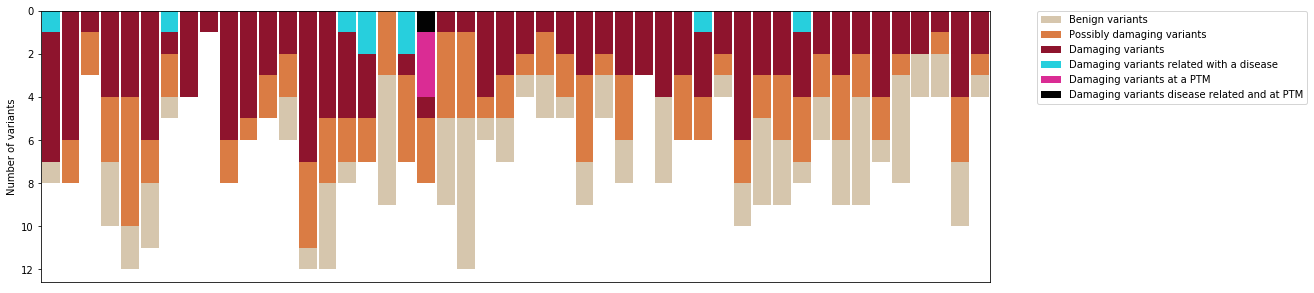

In [42]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_bspos_total_clus_cut,binding_site_gnum,True,True) # legendOut, downwards
#classA/verticalZoom.png

### 5.2  Clustering Aminergic, heatmap and horizontal sum

Benign: #DDC8A6 -> crudo
Pos Dam: #F3752B -> Orange
Dam: #A20021 -> Red
No data: #EDEDF4 -> white
Dam + Dis: #09E9FB -> blue
Dam + PTM: #F70F9A -> pink
Dam + Dis + PTM: #030303 -> black
['#DDC8A6', '#F3752B', '#A20021', '#EDEDF4', '#09E9FB', '#F70F9A', '#030303']


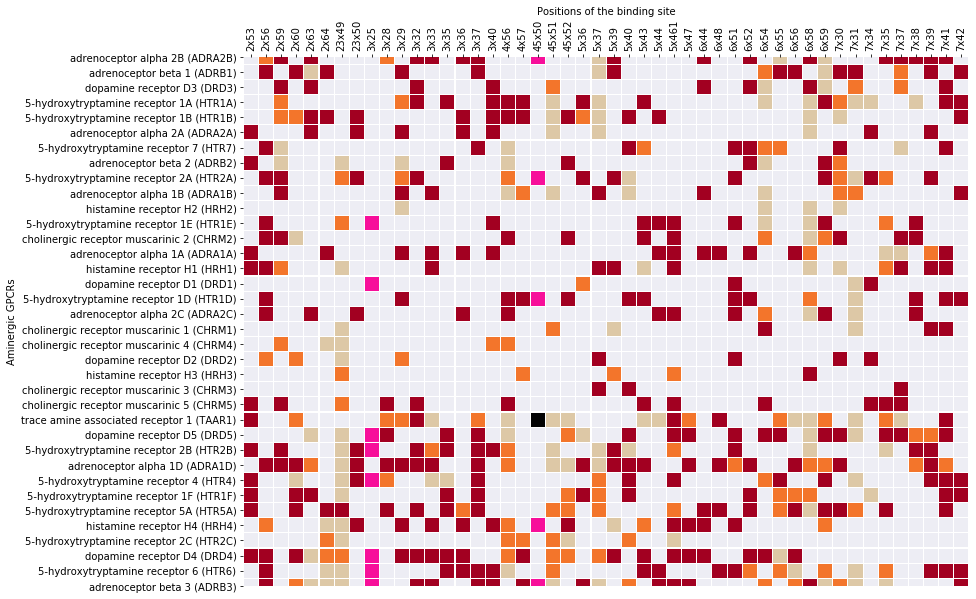

In [43]:
gpcr_bspos_total_amin=anls.cluster_df(gpcr_bspos_total_amin)#cluster the dataframe

rows=list(gpcr_bspos_total_amin.index.values)
gpcr_bspos_count_amin=dict(zip(aminergicLong,[0]*len(aminergicLong)))
gpcr_bspos_count_amin_df=pd.DataFrame(list(gpcr_bspos_count_amin.items()),
                      columns=['GPCR','Count'])


heatmap_only_total_BS(gpcr_bspos_total_amin, colorsToHeatmap,binding_site_gnum,13,13)
#amin/heatmap.png

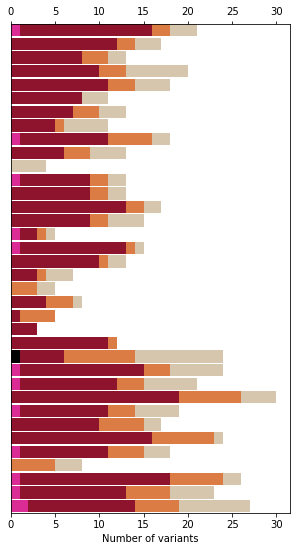

In [44]:
# horizontal barplot
def heatmap_total_horizontal_sum_mixed_cluster(dataFrame, small=False, dis=False, ptm=False, disPTM=False, legendOut=False, yText=False):
    ''' Build the horizontal barplot, sum for each GPCR, with the disease and PTM info.
    Add True as 2nd parameter if the heatmap will be for only aminergic (smaller df).
    Add True as 3rd parameter if there are ptm values to be displayed (pink).
    Add True as 4th parameter if there are Dis + ptm values to be displayed (black).
    Add True as 5th parameter if you want the legend out of the plot
    dd True as 6th parameter if you want to hide the ylabels'''
    # build dictionaries and df with only damaging:
    rows=list(dataFrame.index.values)
    (gpcr_ibspos_count_ben_df,df_ben)=anls.get_counts(dataFrame,'benign',rows)#bening
    (gpcr_ibspos_count_damaging_df,df_damaging)=anls.get_counts(dataFrame,'dam',rows)#damaging
    # and only possibly damaging and damaging
    (gpcr_ibspos_count_all_df,df_all)=anls.get_counts(dataFrame,'posDam',rows)# possibly damaging and damaging
    
    # dam+dis
    (gpcr_ibspos_count_dis_df,df_dis)=anls.get_counts(dataFrame,'disPTMjoin',rows)#damaging+disease
    # dam+ptm
    (gpcr_ibspos_count_ptm_df,df_ptm)=anls.get_counts(dataFrame,'PTMjoin',rows)#damaging+ptm
    # dam+dis+ptm
    (gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)=anls.get_counts(dataFrame,'join',rows)#damaging+dis+ptm

    abundance_dist_damaging_df=anls.get_count_dist(gpcr_ibspos_count_damaging_df,df_damaging)
    abundance_dist_all_df=anls.get_count_dist(gpcr_ibspos_count_all_df,df_all)
    abundance_dist_bening_df=anls.get_count_dist(gpcr_ibspos_count_ben_df,df_ben)
    
    abundance_dist_dis_df=anls.get_count_dist(gpcr_ibspos_count_dis_df,df_dis)
    abundance_dist_ptm_df=anls.get_count_dist(gpcr_ibspos_count_ptm_df,df_ptm)
    abundance_dist_dis_ptm_df=anls.get_count_dist(gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)
    
    #reprentation of both dataframes in a barplot
    grid = plt.GridSpec(1, 1)
    if not small:
        fig, ax = plt.subplots(figsize=(4,40))
    else: 
        fig, ax = plt.subplots(figsize=(5,9))
    #benign
    ax1=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_ben_df , x="Count",y="GPCR",color="#DDC8A6",label="Benign variants")
    axB.get_yaxis()
#     axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    if not yText:
        axB.get_yaxis().set_visible(False) # not visible
        
    # pos dam
    ax2=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#F3752B",label="Possibly-damaging variants")
    axB.get_yaxis()
#     axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # dam
    ax3=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_damaging_df , x="Count",y="GPCR",color="#A20021",label="Damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
#     axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    # dis
    if dis:
        ax4=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_df , x="Count",y="GPCR",color="#09E9FB",label="Damaging variants related with diseases")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
#         axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    
    # PTM
    if ptm:
        ax5=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_ptm_df , x="Count",y="GPCR",color="#F70F9A",label="Damaging variants at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
#         axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    # PTM+Dis    
    if disPTM:
        ax6=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_ptm_df , x="Count",y="GPCR",color="#030303",label="Damaging variants disease related at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
#         axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
#     if legendOut:
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     else:
#         plt.legend()
    plt.show()
    return None


heatmap_total_horizontal_sum_mixed_cluster(gpcr_bspos_total_amin,True,False,True,True,True)#small, notDis(blue), PTMs(pink), PTM+Dis(black), legend out
# amin/horizontal.png

# Mapping
Now we will map in a template, an aminergic GPCR, the variants colored by frequency.
+ Positions 'more porbably damaged when mutated' with more score '2' (and '1'). 
+ Positions 'more ralated with diseases', colored by number of related diseases/number of different variants.
+ Positions related with PTMs (none in this region).
+ Positions 'more interesting positions', the ones that have score 2 and are related with diseases/PTMs, for class A and aminergic.
### 1. Positions more porbably damaged when mutated

In [45]:
gpcr="HTR2A" # Template, 5-hydroxytryptamine receptor 2A, drug target, aminergic
pdbname="6A94" # inactive structure
pdb_path=os.path.join(path_to_project,"Data/pdb_files/")
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=anls.gpcr_pdb_dict_fom_json(dictpath+json_filename)


mypdb=pdbname+".pdb"
mypdbpath=os.path.join(pdb_path,mypdb)
mol = Molecule(mypdbpath)

#TM1
gpcr_sel="protein and chain A and resid < 102"
mol.reps.add(sel=gpcr_sel,color="#4993f1",style='Cartoon')
# ICL1
gpcr_sel="protein and chain A and resid > 102 and resid < 107"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='Cartoon')

# TM2
gpcr_sel="protein and chain A and resid > 107 and resid < 139"
mol.reps.add(sel=gpcr_sel,color="#4993f1",style='Cartoon')
# ECL1
gpcr_sel="protein and chain A and resid > 139 and resid < 144"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='Cartoon')

# TM3
gpcr_sel="protein and chain A and resid > 144 and resid < 180"
mol.reps.add(sel=gpcr_sel,color="#4993f1",style='Cartoon')
# ICL2
gpcr_sel="protein and chain A and resid > 180 and resid < 188"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='Cartoon')

# TM4
gpcr_sel="protein and chain A and resid > 188 and resid < 218"
mol.reps.add(sel=gpcr_sel,color="#4993f1",style='Cartoon')
# ECL2
gpcr_sel="protein and chain A and resid > 218 and resid < 231"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='Cartoon')

# TM5
gpcr_sel="protein and chain A and resid > 231 and resid < 273"
mol.reps.add(sel=gpcr_sel,color="#4993f1",style='Cartoon')
# ICL3
gpcr_sel="protein and chain A and resid > 273 and resid < 312"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='Cartoon')

# TM6
gpcr_sel="protein and chain A and resid > 312 and resid < 350"
mol.reps.add(sel=gpcr_sel,color="#4993f1",style='Cartoon')
# ECL3
gpcr_sel="protein and chain A and resid > 350 and resid < 354"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='Cartoon')

# TM7
gpcr_sel="protein and chain A and resid > 354 and resid < 384"
mol.reps.add(sel=gpcr_sel,color="#4993f1",style='Cartoon')
# H8
gpcr_sel="protein and chain A and resid > 384 and resid < 398"
mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='Cartoon')




mol.center()
mol.camera = 'orthographic'
mol.view()

_ColormakerRegistry()

NGLWidget()

In [46]:
def min_max_freqs_percentage(freqMin, freqMax):
    '''Compute the min and max frequencies in % in a list, min and max'''
    values=[]
    values.append(freqMin*100/len(all_gpcrs_axes))
    values.append(freqMax*100/len(all_gpcrs_axes))
    return values

def create_reps_colormap(gpcr,pdbName,pdbPath,vars_display,colorPalette='YlOrRd',rep_chains=False):
    ''' Configuration of a view of a GPCR with its varints of the BS in VDW representantion and
    color depending on the number of times the variants appear in that position for all the GPCRs.
    norm is used to spread the freq values for all the 61 colors, otherwise not all the color scale
    may be reached'''
     
    pdb=pdbName
    affected_vars=[]
    unaffected_vars=[]
    unknown_vars=[]
    rep_chains=set()
        
    color_dic={}
    freq_set=set()
    for element in vars_display:
        freq_set.add(element['value'])
    freq_unique_sorted=list(freq_set)
    freq_unique_sorted.sort()
    norm_colors=[]
    
    if colorPalette=='Blues':
        color_map_long=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)+10).as_hex()
        color_map=color_map_long[10:]
        color_map.insert(0,'#ffffff')
    elif colorPalette=='RdPu': 
        color_map=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)).as_hex()
        color_map.insert(0,'#ffffff')
    else:
        color_map=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)).as_hex()
    print('Frequencies:',freq_unique_sorted)
#     print(color_map)
    print('The min and max values of the frequencies in percentage:')
    print(min_max_freqs_percentage(freq_unique_sorted[0],freq_unique_sorted[-1]))#min and max in %
    
    for i in range(0,len(freq_unique_sorted)):# build dictionary frequency:color
        color_dic[freq_unique_sorted[i]]=color_map[i]    
    
    if rep_chains: 
        gpcr_sel="protein and (%s)" % " or ".join(rep_chains)
    else:
        gpcr_sel="protein and chain A and resid < 1000"
    mypdb=pdb+".pdb"
    mypdbpath=os.path.join(pdbPath,mypdb)
    mol = Molecule(mypdbpath)
    mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='NewCartoon')
#     mol.reps.add(sel=gpcr_sel,style='VDW')

    for var in vars_display:
#         print(var['value'], color_dic[var['value']])
        mysel="(name CA and resid "+var["pdb_pos"]+" and chain "+var["chain"]+")"
        mol.reps.add(sel=mysel ,color=color_dic[var['value']],style='VDW')
    mol.center()
    mol.camera = 'orthographic'
    #mol.view()
    return mol

In [47]:
# return a dictionary with the position and frequency: score_freq_dict
# score 2:
score_freq_dict=anls.freq_score_dic(gpcr_bspos,binding_site_gnum,2)
# score 1:
score_freq_dict_1=anls.freq_score_dic(gpcr_bspos,binding_site_gnum,1)
# score 0:
score_freq_dict_0=anls.freq_score_dic(gpcr_bspos,binding_site_gnum,0)
# score 3:
score_freq_dict_3=anls.freq_score_dic(gpcr_bspos,binding_site_gnum,3)

# % of cells in the heatmap that have score 2:
anls.percentage_cells(all_gpcrs_axes,score_freq_dict,2)
#score 1:
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_1,1)
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_0,0)
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_3,3)

The 17.13850174216028 % of the cells have score 2
The 9.647212543554007 % of the cells have score 1
The 11.27322880371661 % of the cells have score 0
The 61.9410569105691 % of the cells have score 3


In [48]:
gpcr="HTR2A" # Template, 5-hydroxytryptamine receptor 2A, drug target, aminergic
pdbname="6A94" # inactive structure
pdb_path=os.path.join(path_to_project,"Data/pdb_files/")
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=anls.gpcr_pdb_dict_fom_json(dictpath+json_filename)

# score 2
vars_display=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict.items():
    score_var_info={}
    if gnum in gpcr_pdb:
        score_var_info["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info["value"]=freq
        vars_display.append(score_var_info)
vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display, 'Reds')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [22, 23, 31, 32, 33, 35, 37, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 61, 63, 69, 72, 73, 76]
The min and max values of the frequencies in percentage:
[7.665505226480836, 26.480836236933797]


NGLWidget()

In [49]:
# score 1

vars_display_1=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict_1.items():
    score_var_info_1={}
    if gnum in gpcr_pdb:
        score_var_info_1["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_1["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_1["value"]=freq
        vars_display_1.append(score_var_info_1)

vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_1, 'Reds')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [6, 7, 11, 14, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 40, 41, 43]
The min and max values of the frequencies in percentage:
[2.0905923344947737, 14.982578397212544]


NGLWidget()

In [50]:
# score 0

vars_display_0=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict_0.items():
    score_var_info_0={}
    if gnum in gpcr_pdb:
        score_var_info_0["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_0["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_0["value"]=freq
        vars_display_0.append(score_var_info_0)

vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_0, 'Reds')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [4, 5, 9, 12, 13, 15, 17, 18, 21, 22, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 50, 51, 53, 54, 56, 59, 61]
The min and max values of the frequencies in percentage:
[1.3937282229965158, 21.254355400696863]


NGLWidget()

### 2. Positions more ralated with diseases
#### 2.1 Colored by number of related diseases

In [51]:
relDiseases_freq_dict=anls.freq_disease_dic(gpcr_bspos_dis, binding_site_gnum)
print(relDiseases_freq_dict)
# Related diseases of variants in each position
vars_display_relDis=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in relDiseases_freq_dict.items():
    score_var_info_relDis={}
    if gnum in gpcr_pdb:
        score_var_info_relDis["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_relDis["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_relDis["value"]=freq
        vars_display_relDis.append(score_var_info_relDis)

vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_relDis,'Blues')
vieww.camera = 'orthographic'
vieww.view()

{'2x53': 8, '2x56': 0, '2x59': 1, '2x60': 2, '2x63': 47, '2x64': 0, '23x49': 8, '23x50': 0, '3x25': 3, '3x28': 4, '3x29': 3, '3x32': 1, '3x33': 0, '3x35': 1, '3x36': 1, '3x37': 3, '3x40': 2, '4x56': 24, '4x57': 7, '45x50': 1, '45x51': 1, '45x52': 2, '5x36': 2, '5x37': 0, '5x39': 3, '5x40': 0, '5x43': 2, '5x44': 2, '5x461': 2, '5x47': 1, '6x44': 16, '6x48': 1, '6x51': 0, '6x52': 1, '6x54': 0, '6x55': 1, '6x56': 0, '6x58': 0, '6x59': 1, '7x30': 0, '7x31': 3, '7x34': 9, '7x35': 1, '7x37': 5, '7x38': 0, '7x39': 0, '7x41': 1, '7x42': 3}
Frequencies: [0, 1, 2, 3, 4, 5, 7, 8, 9, 16, 24, 47]
The min and max values of the frequencies in percentage:
[0.0, 16.37630662020906]


NGLWidget()

#### 2.2 Colored by number of different variants
In here we will just consider the variants related with diseases that are also score 2.

In [52]:
disDamaging_freq_dict=anls.freq_score_dic(gpcr_bspos_total_clus,binding_site_gnum,4)
# disDamaging_freq_dict
anls.percentage_cells(all_gpcrs_axes,disDamaging_freq_dict,4)

The 0.20325203252032523 % of the cells have score 4


In [53]:
# score 4, dis+damaging
vars_display_dis=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in disDamaging_freq_dict.items():
    score_var_info_dis={}
    if gnum in gpcr_pdb:
        score_var_info_dis["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_dis["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_dis["value"]=freq
        vars_display_dis.append(score_var_info_dis)
vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_dis,'Reds')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [0, 1, 2]
The min and max values of the frequencies in percentage:
[0.0, 0.6968641114982579]


NGLWidget()

### 2.3 Variants affecting PTMs


In [74]:
def freq_score_dic(dataFrame, listGnum, score, PTMDis=False):
    '''Build a dictionary with keys as positions and values as the number of times the position
    appears with the corresponding score
    Add True if there are black cells, score 6'''
    freq_dic={}
    freq_dic_aux={}
    
    gpcr_pos_count_bybs_damaging=dict(zip(listGnum,[0]*len(listGnum)))

    for pos in gpcr_pos_count_bybs_damaging.keys():
        if not PTMDis:
            count_damaging=len([varval for varval in dataFrame[pos].values if varval==score])
        else:
            count_damaging=len([varval for varval in dataFrame[pos].values if varval==score or varval==6])

        gpcr_pos_count_bybs_damaging[pos]=count_damaging
#         print(pos,count_damaging)
    axisText=anls.defineRegion(listGnum)
    gpcr_pos_count_bybs_damaging_df=pd.DataFrame(list(gpcr_pos_count_bybs_damaging.items()),
                          columns=[axisText,'Count'])
#     print(gpcr_pos_count_bybs_damaging_df)
    freq_dic_aux=gpcr_pos_count_bybs_damaging_df.set_index(axisText).T.to_dict('list')
    for key, element in freq_dic_aux.items():
        freq_dic[key]=int(freq_dic_aux[key][0])
    
    return freq_dic

ptm_freq_dict=freq_score_dic(gpcr_bspos_total_clus,binding_site_gnum,5,True)


# Parece que en las posiciones de los DB hay 7 (3x25) PTMs no DBs ocultas in 1 en (45x50)

In [75]:
ptm_freq_dict=anls.freq_score_dic(gpcr_bspos_total_clus,binding_site_gnum,5)
print(ptm_freq_dict)
anls.percentage_cells(all_gpcrs_axes,ptm_freq_dict,5)

{'2x53': 0, '2x56': 0, '2x59': 0, '2x60': 0, '2x63': 0, '2x64': 0, '23x49': 0, '23x50': 0, '3x25': 63, '3x28': 0, '3x29': 0, '3x32': 0, '3x33': 0, '3x35': 0, '3x36': 0, '3x37': 0, '3x40': 0, '4x56': 0, '4x57': 0, '45x50': 60, '45x51': 0, '45x52': 0, '5x36': 0, '5x37': 0, '5x39': 0, '5x40': 0, '5x43': 0, '5x44': 0, '5x461': 0, '5x47': 0, '6x44': 0, '6x48': 0, '6x51': 0, '6x52': 0, '6x54': 0, '6x55': 0, '6x56': 0, '6x58': 0, '6x59': 0, '7x30': 0, '7x31': 0, '7x34': 0, '7x35': 0, '7x37': 0, '7x38': 0, '7x39': 0, '7x41': 0, '7x42': 1}
The 0.9001161440185831 % of the cells have score 5


In [76]:
# score 5, dis+PTM
vars_display_ptm=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in ptm_freq_dict.items():
    score_var_info_ptm={}
    if gnum in gpcr_pdb:
        score_var_info_ptm["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_ptm["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_ptm["value"]=freq
        vars_display_ptm.append(score_var_info_ptm)
vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_ptm,'RdPu')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [0, 1, 60, 63]
The min and max values of the frequencies in percentage:
[0.0, 21.951219512195124]


NGLWidget()

In [85]:
ptm_freq_dict_type={'2x53': 0, '2x56': 0, '2x59': 0, '2x60': 0, '2x63': 0, '2x64': 0, '23x49': 0, '23x50': 0, '3x25': 3, '3x28': 0, '3x29': 0, '3x32': 0, '3x33': 0, '3x35': 0, '3x36': 0, '3x37': 0, '3x40': 0, '4x56': 0, '4x57': 0, '45x50': 3, '45x51': 0, '45x52': 2, '5x36': 2, '5x37': 0, '5x39': 0, '5x40': 0, '5x43': 0, '5x44': 0, '5x461': 0, '5x47': 0, '6x44': 0, '6x48': 0, '6x51': 0, '6x52': 0, '6x54': 0, '6x55': 0, '6x56': 0, '6x58': 2, '6x59': 0, '7x30': 0, '7x31': 0, '7x34': 0, '7x35': 0, '7x37': 0, '7x38': 0, '7x39': 0, '7x41': 0, '7x42': 1}

In [86]:
# color by PTM type

def create_reps_colormap_PTMtype(gpcr,pdbName,pdbPath,vars_display,rep_chains=False):
    ''' Configuration of a view of a GPCR with its varints of the BS in VDW representantion and
    color depending on the number of times the variants appear in that position for all the GPCRs.
    norm is used to spread the freq values for all the 61 colors, otherwise not all the color scale
    may be reached'''
     
    pdb=pdbName
    affected_vars=[]
    unaffected_vars=[]
    unknown_vars=[]
    rep_chains=set()
        
    color_dic={}
    freq_set=set()
    for element in vars_display:
        freq_set.add(element['value'])
    freq_unique_sorted=list(freq_set)
    freq_unique_sorted.sort()
    norm_colors=[]
    
    color_map=['#ffffff',"#f977ca" , '#f8589e','#801f4a'] # white, modres, glyco, db
    print('Frequencies:',freq_unique_sorted)
#     print(color_map)
    print('The min and max values of the frequencies in percentage:')
    print(min_max_freqs_percentage(freq_unique_sorted[0],freq_unique_sorted[-1]))#min and max in %
    
    for i in range(0,len(freq_unique_sorted)):# build dictionary frequency:color
        color_dic[freq_unique_sorted[i]]=color_map[i]    
    
    if rep_chains: 
        gpcr_sel="protein and (%s)" % " or ".join(rep_chains)
    else:
        gpcr_sel="protein and chain A and resid < 1000"
    mypdb=pdb+".pdb"
    mypdbpath=os.path.join(pdbPath,mypdb)
    mol = Molecule(mypdbpath)
    mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='NewCartoon')
#     mol.reps.add(sel=gpcr_sel,style='VDW')

    for var in vars_display:
#         print(var['value'], color_dic[var['value']])
        mysel="(name CA and resid "+var["pdb_pos"]+" and chain "+var["chain"]+")"
        mol.reps.add(sel=mysel ,color=color_dic[var['value']],style='VDW')
    mol.center()
    mol.camera = 'orthographic'
    #mol.view()
    return mol

vars_display_ptmm=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in ptm_freq_dict_type.items():
    score_var_info_ptm={}
    if gnum in gpcr_pdb:
        score_var_info_ptm["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_ptm["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_ptm["value"]=freq
        vars_display_ptmm.append(score_var_info_ptm)
        
vieww=create_reps_colormap_PTMtype(gpcr,pdbname,pdb_path,vars_display_ptmm,'RdPu')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [0, 1, 2, 3]
The min and max values of the frequencies in percentage:
[0.0, 1.0452961672473868]


NGLWidget()

In [90]:
# cm mapping
naBS=['2x50', '3x39', '7x45', '7x46'] # Sodium binding site
ionicLock=['3x50', '6x30'] # Ionic lock
rotTogg=['6x48'] # Rotamer toggle switch
cm_gnum= naBS + ionicLock + rotTogg # all positions in a list
consMotifs = [naBS, ionicLock, rotTogg] # all conserved motifs, list if lists
cm_freq_dict_type={'2x50':1,'3x39':1, '7x45':1, '7x46':1,'3x50':2, '6x30':2, '6x48':3}

In [93]:
# color by PTM type

def create_reps_colormap_CM(gpcr,pdbName,pdbPath,vars_display,rep_chains=False):
    ''' Configuration of a view of a GPCR with its varints of the BS in VDW representantion and
    color depending on the number of times the variants appear in that position for all the GPCRs.
    norm is used to spread the freq values for all the 61 colors, otherwise not all the color scale
    may be reached'''
     
    pdb=pdbName
    affected_vars=[]
    unaffected_vars=[]
    unknown_vars=[]
    rep_chains=set()
        
    color_dic={}
    freq_set=set()
    for element in vars_display:
        freq_set.add(element['value'])
    freq_unique_sorted=list(freq_set)
    freq_unique_sorted.sort()
    norm_colors=[]
    
    color_map=["#7dcea0" , '#229954','#186a3b'] # na, il, rot
    print('Frequencies:',freq_unique_sorted)
#     print(color_map)
    print('The min and max values of the frequencies in percentage:')
    print(min_max_freqs_percentage(freq_unique_sorted[0],freq_unique_sorted[-1]))#min and max in %
    
    for i in range(0,len(freq_unique_sorted)):# build dictionary frequency:color
        color_dic[freq_unique_sorted[i]]=color_map[i]    
    
    if rep_chains: 
        gpcr_sel="protein and (%s)" % " or ".join(rep_chains)
    else:
        gpcr_sel="protein and chain A and resid < 1000"
    mypdb=pdb+".pdb"
    mypdbpath=os.path.join(pdbPath,mypdb)
    mol = Molecule(mypdbpath)
    mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='NewCartoon')
#     mol.reps.add(sel=gpcr_sel,style='VDW')

    for var in vars_display:
#         print(var['value'], color_dic[var['value']])
        mysel="(name CA and resid "+var["pdb_pos"]+" and chain "+var["chain"]+")"
        mol.reps.add(sel=mysel ,color=color_dic[var['value']],style='VDW')
    mol.center()
    mol.camera = 'orthographic'
    #mol.view()
    return mol

vars_display_cm=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in cm_freq_dict_type.items():
    score_var_info_ptm={}
    if gnum in gpcr_pdb:
        score_var_info_ptm["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_ptm["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_ptm["value"]=freq
        vars_display_cm.append(score_var_info_ptm)
        
vieww=create_reps_colormap_CM(gpcr,pdbname,pdb_path,vars_display_cm)
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [1, 2, 3]
The min and max values of the frequencies in percentage:
[0.34843205574912894, 1.0452961672473868]


NGLWidget()